# load data 

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
# from jupyterthemes import jtplot
# jtplot.style(theme='gruvboxd')
# jtplot.style(context='talk', fscale=1.4, spines=False, gridlines='--')
# jtplot.style(ticks=True, grid=False, figsize=(6.5, 5))

import pandas as pd
import numpy as np
import pickle
import gc

In [7]:
# train_test = pd.read_csv("../data_preprocess/df.csv")

# train = train_test[train_test['repay_amt'].notnull()]
# test = train_test[train_test['repay_amt'].isnull()]

# train.to_csv('./train_set.csv',index=False)
# test.to_csv('./test_set.csv',index=False)
train_set = pd.read_csv('./train_set.csv')

In [8]:
X = train_set.drop(['repay_audit_delta'],axis=1)
y = train_set['repay_audit_delta'].astype('int')

repay_amt = train_set['repay_amt']
due_amt = train_set['due_amt']

del train_set
gc.collect()

1755

# define metrics

In [9]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,log_loss,accuracy_score,confusion_matrix,classification_report
import itertools

In [7]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(12,8),dpi=120)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return plt

In [8]:
def eval_info(model,y_true,y_pred,y_pred_prob,cm):
    
    print("------%s classification_report------\n" % model.__class__.__name__,
          classification_report(y_true,y_pred))
    
    y_pred_prob_max = [y_pred_prob[i][y_pred[i]] for i in range(len(y_pred))]
    pred_amt = due_amt[y_true.index]*y_pred_prob_max
    true_amt = repay_amt[y_true.index]
    rmse = np.sqrt(mean_squared_error(true_amt,pred_amt))
    mae = mean_absolute_error(true_amt,pred_amt)
    logloss = log_loss(y_true,y_pred_prob)
    accuracy = accuracy_score(y_true,y_pred)
    
    print("-----the best model eval info-----\n",
            "RMSE:{}\n".format(rmse),
            "MAE:{}\n".format(mae),
            "logloss:{}\n".format(logloss),
            "accuracy:{}\n".format(accuracy)
         )
    plot_confusion_matrix(cm, classes=y_true.unique())
    

# split data

In [10]:
from sklearn.model_selection import train_test_split
# from sklearn.model_selection import StratifiedKFold

train_x,valid_x,train_y,valid_y = train_test_split(X,y,stratify=y,test_size=0.4,random_state=666)
# sfk = StratifiedKFold(n_splits=3,shuffle=True,random_state=666)

In [11]:
del X,y
gc.collect()

# valid_x,test_x,valid_y,test_y = train_test_split(valid_x,valid_y,stratify=valid_y,test_size=0.3,random_state=666)

0

In [12]:
train_repay_amt = train_x['repay_amt']
train_due_amt = train_x['due_amt']

valid_repay_amt = valid_x['repay_amt']
valid_due_amt = valid_x['due_amt']

train_x.drop(['repay_amt'],axis=1,inplace=True)
valid_x.drop(['repay_amt'],axis=1,inplace=True)
# test_x.drop(['repay_amt'],axis=1,inplace=True)

# single model

## logistic regression

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [11]:
param_grid =  {
            'penalty':['l1','l2'],
            'C':[0.035,0.1],
            'solver':['saga'], #‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’
            'class_weight':['balanced'],
            'multi_class':['multinomial'],
            'random_state':[666],
            'n_jobs':[-1]
}

LR = GridSearchCV(LogisticRegression(),param_grid,cv=sfk,scoring='neg_log_loss')
LR.fit(train_x,train_y)

print("best score: %f \n best model: %s" % (LR.best_score_, LR.best_estimator_))

LR_best = LR.best_estimator_
y_pred =LR_best.predict(test_x)
y_pred_prob = LR_best.predict_proba(test_x)
train_score = LR_best.score(train_x,train_y)
test_score = LR_best.score(test_x,test_y)
cm = confusion_matrix(test_y,y_pred)

eval_info(LR_best,test_y,y_pred,y_pred_prob,cm)
print( "train_score:",train_score,"\n","test_score:",test_score)

print("logistic model parameters shape:",LR_best.coef_.shape,"\n",
     "count of non-zero elements:",np.count_nonzero(LR_best.coef_))

## Decision Tree

In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

### train

 best score: -3.043707 
 best model: DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=8,
            max_features=0.6, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=666,
            splitter='best')


/home/xgg/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


------DecisionTreeClassifier classification_report------
              precision    recall  f1-score   support

          0       0.14      0.31      0.20      3734
          1       0.04      0.09      0.06      1886
          2       0.03      0.08      0.04      1108
          3       0.00      0.00      0.00       979
          4       0.00      0.02      0.01       984
          5       0.04      0.00      0.00       984
          6       0.01      0.03      0.02       979
          7       0.03      0.00      0.00      1018
          8       0.03      0.06      0.03      1060
          9       0.01      0.02      0.02      1101
         10       0.00      0.00      0.00      1158
         11       0.02      0.08      0.03      1257
         12       0.00      0.00      0.00      1311
         13       0.00      0.00      0.00      1420
         14       0.01      0.02      0.02      1536
         15       0.01      0.03      0.02      1598
         16       0.02      0.07      0.

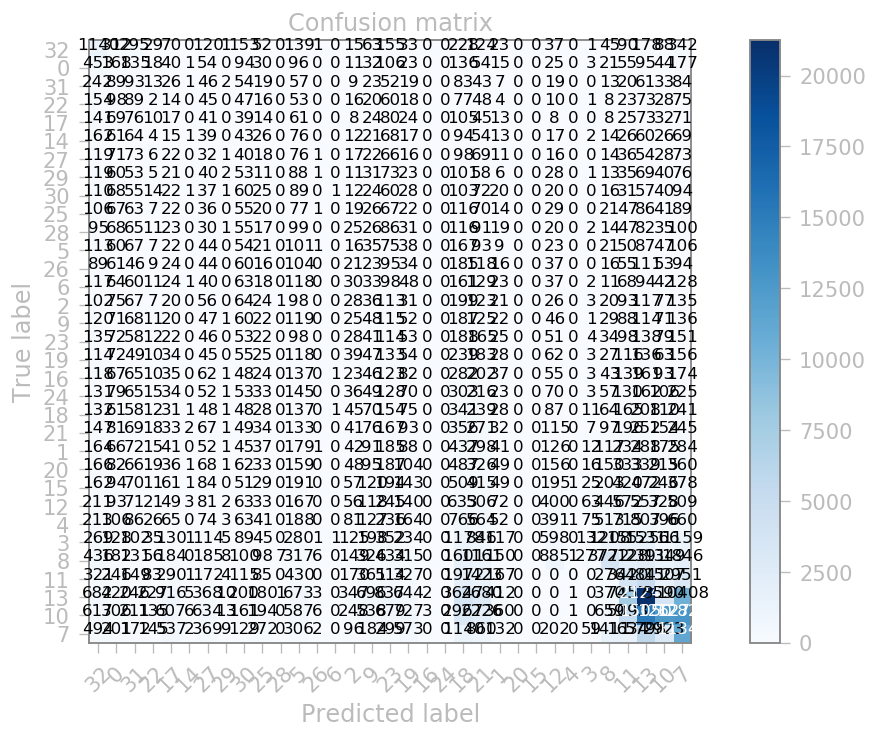

In [30]:
param_grid = {#"criterion":[''],
               "max_depth":[5,6,8],
                'max_features':[0.8,0.6],
#               "min_impurity_decrease":[0],
#              "min_samples_split":[2],
#               "min_samples_leaf":[1], # 样本量不大不需管
#               "max_leaf_nodes":[19],
#               'min_weight_fraction_leaf':[0.04],
              'class_weight':['balanced'],
              'random_state':[666],
             }
DT = GridSearchCV(DecisionTreeClassifier(),param_grid,cv=sfk,scoring='neg_log_loss')
DT.fit(train_x,train_y)


print(" best score: %f \n best model: %s" % (DT.best_score_, DT.best_estimator_))

DT_best = DT.best_estimator_

y_pred =DT_best.predict(test_x)
y_pred_prob = DT_best.predict_proba(test_x)

train_score = DT_best.score(train_x,train_y)
test_score = DT_best.score(test_x,test_y)

cm = confusion_matrix(test_y,y_pred)

eval_info(DT_best,test_y,y_pred,y_pred_prob,cm)
print( "train_score:",train_score,"\n","test_score:",test_score)

### save

In [32]:
# save model
with open("../save_models/DT.txt",'wb') as f:
    pickle.dump(DT_best,f)

### predict

In [75]:
# predict
test_all = pd.read_csv("./another data/test_all_clean.csv",index_col=['cust_group','cust_id'])
y_pred = DT_best.predict(test_all)
y_pred_prob = DT_best.predict_proba(test_all)[:,1]

print(pd.Series(y_pred).value_counts())
pred_result = pd.Series(y_pred_prob,index=test_all.index.get_level_values(level=1),name="pred_prob")
pred_result.index.name = "cust_id"
pred_result.sort_index().to_csv("./predict/pred_result_DT.csv",header=True)

0    6513
1    3487
dtype: int64


## random forest

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

### train

 best score: -3.308161 
 best model: RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=6, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=140, n_jobs=-1, oob_score=False, random_state=666,
            verbose=0, warm_start=False)
------RandomForestClassifier classification_report------
              precision    recall  f1-score   support

          0       0.06      0.41      0.10      3734
          1       0.03      0.14      0.04      1886
          2       0.02      0.03      0.02      1108
          3       0.01      0.06      0.02       979
          4       0.01      0.03      0.02       984
          5       0.01      0.03      0.02       984
          6       0.01      0.05      0.02       979
          7       0.01      0.01      0.01      1018
  

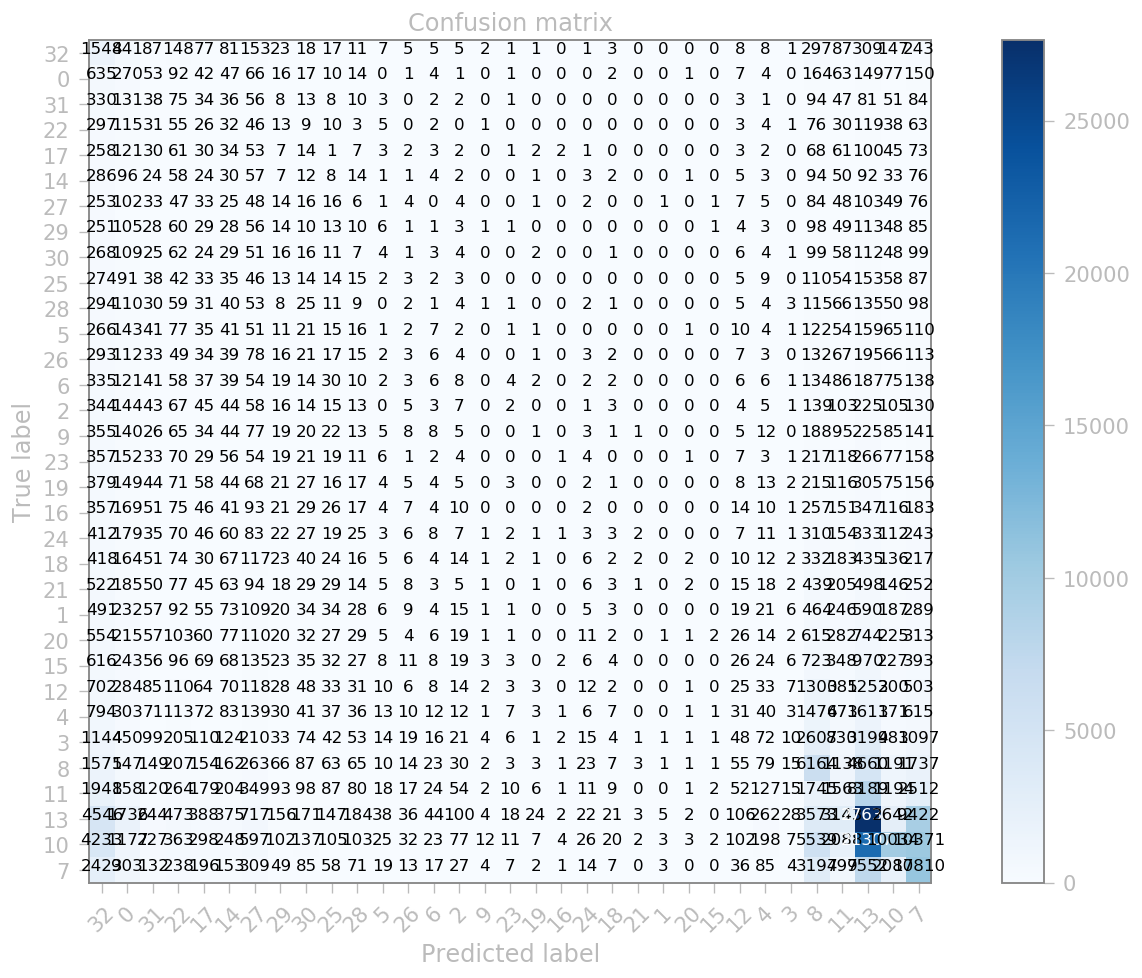

In [34]:
param_grid = {
#             'criterion':[''],
            'n_estimators':[140,100],
#             'max_features':["sqrt"],
            'max_depth':[6,5,4],
#              "min_samples_split":[], # 样本量不大不需管
#               "min_samples_leaf":[], # 样本量不大不需管
#             "max_leaf_nodes":[13,15,20],
#             'min_impurity_decrease':[0],
            'class_weight':['balanced'],
            'n_jobs':[-1],
            'random_state':[666],
             }


RF = GridSearchCV(RandomForestClassifier(),param_grid,cv=sfk,scoring='neg_log_loss')
RF.fit(train_x,train_y)

print(" best score: %f \n best model: %s" % (RF.best_score_, RF.best_estimator_))


RF_best = RF.best_estimator_

y_pred =RF_best.predict(test_x)
y_pred_prob = RF_best.predict_proba(test_x)

train_score = RF_best.score(train_x,train_y)
test_score = RF_best.score(test_x,test_y)

cm = confusion_matrix(test_y,y_pred)

eval_info(RF_best,test_y,y_pred,y_pred_prob,cm)
print( "train_score:",train_score,"\n","test_score:",test_score)

### save

In [35]:
# save model
with open("../save_models/RF.txt",'wb') as f:
    pickle.dump(RF_best,f)

### predict

In [78]:
# predict
test_all = pd.read_csv("./another data/test_all_clean.csv",index_col=['cust_group','cust_id'])
y_pred = RF_best.predict(test_all)
y_pred_prob = RF_best.predict_proba(test_all)[:,1]

print(pd.Series(y_pred).value_counts())
pred_result = pd.Series(y_pred_prob,index=test_all.index.get_level_values(level=1),name="pred_prob")
pred_result.index.name = "cust_id"
pred_result.sort_index().to_csv("./predict/pred_result_RF.csv",header=True)

0    7957
1    2043
dtype: int64


## xgb-sklearn

In [38]:
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV

### train

In [ ]:
param_grid = {
    'booster':['gbtree'],
    'objective': ['multi:softmax'], # multi:softmax multi:softprob reg:linear
    'eval_metric':['mlogloss'],
    'n_estimators':[145,80,100],
    'max_depth':[3,4,5],
    'learning_rate':[0.05,0.01],
    'min_child_weight':[5],
    'gamma':[0.05],
    'subsample': [0.8],
    'colsample_bytree': [0.6],
    'reg_alpha': [7],
    'reg_lambda': [5],
#     'scale_pos_weight':[float(len(train_y)-sum(train_y))/float(sum(train_y))],
    'random_state':[0],
#     'n_jobs': [-1],
    'missing': [-1],
    'silent':[True],
    'seed':[666],
}

XGB = GridSearchCV(XGBClassifier(),param_grid,cv=sfk,scoring='neg_log_loss')
XGB.fit(train_x,train_y)

print(" best score: %f \n best model: %s" % (XGB.best_score_, XGB.best_estimator_))


XGB_best = XGB.best_estimator_

y_pred =XGB_best.predict(test_x)
y_pred_prob = XGB_best.predict_proba(test_x)

train_score = XGB_best.score(train_x,train_y)
test_score = XGB_best.score(test_x,test_y)

cm = confusion_matrix(test_y,y_pred)

eval_info(XGB_best,test_y,y_pred,y_pred_prob,cm)
print( "train_score:",train_score,"\n","test_score:",test_score)

### save

In [ ]:
# save model
with open("../save_models/XGB.txt",'wb') as f:
    pickle.dump(XGB_best,f)

### predict

In [86]:
# predict
test_all = pd.read_csv("./another data/test_all_clean.csv",index_col=['cust_group','cust_id'])
y_pred = XGB_best.predict(test_all)
y_pred_prob = XGB_best.predict_proba(test_all)[:,1]

print(pd.Series(y_pred).value_counts())
pred_result = pd.Series(y_pred_prob,index=test_all.index.get_level_values(level=1),name="pred_prob")
pred_result.index.name = "cust_id"
pred_result.sort_index().to_csv("./predict/pred_result_XGB.csv",header=True)

0    9004
1     996
dtype: int64


F:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


## xgb:raw interface

### train

In [1]:
import xgboost as xgb
import pickle

In [ ]:
# with open("../save_models/xgboost_10000.txt",'rb') as model_f:
#     xgb_trained_model = pickle.load(model_f)
xgb_trained_model = xgb.Booster(model_file="../save_models/xgboost_20000.txt")

/home/xgg/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-mlogloss:3.46791	valid-mlogloss:3.46795	train-amt_rmse:580.029	valid-amt_rmse:577.354
Multiple eval metrics have been passed: 'valid-amt_rmse' will be used for early stopping.

Will train until valid-amt_rmse hasn't improved in 6000 rounds.
[2]	train-mlogloss:3.41361	valid-mlogloss:3.41372	train-amt_rmse:578.375	valid-amt_rmse:575.708
[4]	train-mlogloss:3.36483	valid-mlogloss:3.365	train-amt_rmse:577.007	valid-amt_rmse:574.346
[6]	train-mlogloss:3.31877	valid-mlogloss:3.319	train-amt_rmse:575.689	valid-amt_rmse:573.036
[8]	train-mlogloss:3.277	valid-mlogloss:3.27728	train-amt_rmse:574.386	valid-amt_rmse:571.742
[10]	train-mlogloss:3.2384	valid-mlogloss:3.23872	train-amt_rmse:573.079	valid-amt_rmse:570.44
[12]	train-mlogloss:3.20204	valid-mlogloss:3.2024	train-amt_rmse:571.753	valid-amt_rmse:569.121
[14]	train-mlogloss:3.16914	valid-mlogloss:3.16955	train-amt_rmse:570.402	valid-amt_rmse:567.775
[16]	train-mlogloss:3.13831	valid-mlogloss:3.13878	train-amt_rmse:569.174	valid-amt

[168]	train-mlogloss:2.33284	valid-mlogloss:2.33502	train-amt_rmse:497.043	valid-amt_rmse:494.897
[170]	train-mlogloss:2.32917	valid-mlogloss:2.33137	train-amt_rmse:496.428	valid-amt_rmse:494.288
[172]	train-mlogloss:2.32538	valid-mlogloss:2.3276	train-amt_rmse:495.81	valid-amt_rmse:493.672
[174]	train-mlogloss:2.32184	valid-mlogloss:2.32408	train-amt_rmse:495.219	valid-amt_rmse:493.087
[176]	train-mlogloss:2.31834	valid-mlogloss:2.32061	train-amt_rmse:494.621	valid-amt_rmse:492.491
[178]	train-mlogloss:2.31485	valid-mlogloss:2.31712	train-amt_rmse:494.019	valid-amt_rmse:491.894
[180]	train-mlogloss:2.31138	valid-mlogloss:2.31368	train-amt_rmse:493.442	valid-amt_rmse:491.324
[182]	train-mlogloss:2.30809	valid-mlogloss:2.3104	train-amt_rmse:492.887	valid-amt_rmse:490.772
[184]	train-mlogloss:2.30474	valid-mlogloss:2.30707	train-amt_rmse:492.309	valid-amt_rmse:490.199
[186]	train-mlogloss:2.30144	valid-mlogloss:2.30378	train-amt_rmse:491.758	valid-amt_rmse:489.651
[188]	train-mlogloss:2.

[336]	train-mlogloss:2.15658	valid-mlogloss:2.16027	train-amt_rmse:464.33	valid-amt_rmse:462.479
[338]	train-mlogloss:2.15545	valid-mlogloss:2.15916	train-amt_rmse:464.112	valid-amt_rmse:462.266
[340]	train-mlogloss:2.15436	valid-mlogloss:2.15808	train-amt_rmse:463.896	valid-amt_rmse:462.051
[342]	train-mlogloss:2.15326	valid-mlogloss:2.157	train-amt_rmse:463.683	valid-amt_rmse:461.84
[344]	train-mlogloss:2.15213	valid-mlogloss:2.15589	train-amt_rmse:463.457	valid-amt_rmse:461.616
[346]	train-mlogloss:2.15106	valid-mlogloss:2.15484	train-amt_rmse:463.241	valid-amt_rmse:461.402
[348]	train-mlogloss:2.15001	valid-mlogloss:2.15381	train-amt_rmse:463.031	valid-amt_rmse:461.194
[350]	train-mlogloss:2.14895	valid-mlogloss:2.15277	train-amt_rmse:462.813	valid-amt_rmse:460.98
[352]	train-mlogloss:2.14788	valid-mlogloss:2.15172	train-amt_rmse:462.598	valid-amt_rmse:460.767
[354]	train-mlogloss:2.14687	valid-mlogloss:2.15073	train-amt_rmse:462.398	valid-amt_rmse:460.571
[356]	train-mlogloss:2.14

[506]	train-mlogloss:2.09096	valid-mlogloss:2.09639	train-amt_rmse:451.62	valid-amt_rmse:449.942
[508]	train-mlogloss:2.09042	valid-mlogloss:2.09587	train-amt_rmse:451.524	valid-amt_rmse:449.847
[510]	train-mlogloss:2.08988	valid-mlogloss:2.09535	train-amt_rmse:451.424	valid-amt_rmse:449.75
[512]	train-mlogloss:2.08936	valid-mlogloss:2.09485	train-amt_rmse:451.331	valid-amt_rmse:449.658
[514]	train-mlogloss:2.08882	valid-mlogloss:2.09434	train-amt_rmse:451.233	valid-amt_rmse:449.559
[516]	train-mlogloss:2.08827	valid-mlogloss:2.0938	train-amt_rmse:451.13	valid-amt_rmse:449.46
[518]	train-mlogloss:2.08774	valid-mlogloss:2.0933	train-amt_rmse:451.037	valid-amt_rmse:449.364
[520]	train-mlogloss:2.08722	valid-mlogloss:2.09279	train-amt_rmse:450.94	valid-amt_rmse:449.272
[522]	train-mlogloss:2.08671	valid-mlogloss:2.09231	train-amt_rmse:450.852	valid-amt_rmse:449.184
[524]	train-mlogloss:2.0862	valid-mlogloss:2.09182	train-amt_rmse:450.762	valid-amt_rmse:449.095
[526]	train-mlogloss:2.08569

[676]	train-mlogloss:2.05294	valid-mlogloss:2.06022	train-amt_rmse:445.296	valid-amt_rmse:443.783
[678]	train-mlogloss:2.05258	valid-mlogloss:2.05988	train-amt_rmse:445.241	valid-amt_rmse:443.732
[680]	train-mlogloss:2.05219	valid-mlogloss:2.05951	train-amt_rmse:445.18	valid-amt_rmse:443.672
[682]	train-mlogloss:2.05181	valid-mlogloss:2.05916	train-amt_rmse:445.123	valid-amt_rmse:443.624
[684]	train-mlogloss:2.05143	valid-mlogloss:2.05881	train-amt_rmse:445.065	valid-amt_rmse:443.563
[686]	train-mlogloss:2.05107	valid-mlogloss:2.05847	train-amt_rmse:445.012	valid-amt_rmse:443.512
[688]	train-mlogloss:2.05071	valid-mlogloss:2.05812	train-amt_rmse:444.962	valid-amt_rmse:443.463
[690]	train-mlogloss:2.05036	valid-mlogloss:2.05781	train-amt_rmse:444.913	valid-amt_rmse:443.417
[692]	train-mlogloss:2.05001	valid-mlogloss:2.05747	train-amt_rmse:444.868	valid-amt_rmse:443.373
[694]	train-mlogloss:2.04966	valid-mlogloss:2.05715	train-amt_rmse:444.818	valid-amt_rmse:443.325
[696]	train-mlogloss:

[844]	train-mlogloss:2.02528	valid-mlogloss:2.03435	train-amt_rmse:441.431	valid-amt_rmse:440.048
[846]	train-mlogloss:2.025	valid-mlogloss:2.03409	train-amt_rmse:441.396	valid-amt_rmse:440.014
[848]	train-mlogloss:2.02472	valid-mlogloss:2.03383	train-amt_rmse:441.364	valid-amt_rmse:439.98
[850]	train-mlogloss:2.02445	valid-mlogloss:2.03358	train-amt_rmse:441.328	valid-amt_rmse:439.947
[852]	train-mlogloss:2.02415	valid-mlogloss:2.0333	train-amt_rmse:441.289	valid-amt_rmse:439.907
[854]	train-mlogloss:2.02384	valid-mlogloss:2.03301	train-amt_rmse:441.248	valid-amt_rmse:439.869
[856]	train-mlogloss:2.02354	valid-mlogloss:2.03272	train-amt_rmse:441.213	valid-amt_rmse:439.836
[858]	train-mlogloss:2.02323	valid-mlogloss:2.03244	train-amt_rmse:441.174	valid-amt_rmse:439.796
[860]	train-mlogloss:2.02294	valid-mlogloss:2.03216	train-amt_rmse:441.135	valid-amt_rmse:439.76
[862]	train-mlogloss:2.02265	valid-mlogloss:2.0319	train-amt_rmse:441.103	valid-amt_rmse:439.727
[864]	train-mlogloss:2.022

[1012]	train-mlogloss:2.00238	valid-mlogloss:2.01309	train-amt_rmse:438.538	valid-amt_rmse:437.276
[1014]	train-mlogloss:2.00213	valid-mlogloss:2.01287	train-amt_rmse:438.512	valid-amt_rmse:437.251
[1016]	train-mlogloss:2.00186	valid-mlogloss:2.01262	train-amt_rmse:438.483	valid-amt_rmse:437.219
[1018]	train-mlogloss:2.00162	valid-mlogloss:2.01239	train-amt_rmse:438.454	valid-amt_rmse:437.193
[1020]	train-mlogloss:2.00137	valid-mlogloss:2.01216	train-amt_rmse:438.429	valid-amt_rmse:437.168
[1022]	train-mlogloss:2.0011	valid-mlogloss:2.01192	train-amt_rmse:438.403	valid-amt_rmse:437.144
[1024]	train-mlogloss:2.00086	valid-mlogloss:2.01169	train-amt_rmse:438.374	valid-amt_rmse:437.114
[1026]	train-mlogloss:2.00059	valid-mlogloss:2.01144	train-amt_rmse:438.344	valid-amt_rmse:437.085
[1028]	train-mlogloss:2.00033	valid-mlogloss:2.01121	train-amt_rmse:438.309	valid-amt_rmse:437.056
[1030]	train-mlogloss:2.00007	valid-mlogloss:2.01097	train-amt_rmse:438.278	valid-amt_rmse:437.028
[1032]	trai

[1180]	train-mlogloss:1.98209	valid-mlogloss:1.99438	train-amt_rmse:436.104	valid-amt_rmse:434.962
[1182]	train-mlogloss:1.98187	valid-mlogloss:1.99418	train-amt_rmse:436.077	valid-amt_rmse:434.934
[1184]	train-mlogloss:1.98164	valid-mlogloss:1.99397	train-amt_rmse:436.047	valid-amt_rmse:434.912
[1186]	train-mlogloss:1.98138	valid-mlogloss:1.99373	train-amt_rmse:436.011	valid-amt_rmse:434.879
[1188]	train-mlogloss:1.98114	valid-mlogloss:1.99351	train-amt_rmse:435.975	valid-amt_rmse:434.846
[1190]	train-mlogloss:1.98091	valid-mlogloss:1.9933	train-amt_rmse:435.946	valid-amt_rmse:434.818
[1192]	train-mlogloss:1.98068	valid-mlogloss:1.99309	train-amt_rmse:435.92	valid-amt_rmse:434.791
[1194]	train-mlogloss:1.98047	valid-mlogloss:1.99291	train-amt_rmse:435.893	valid-amt_rmse:434.77
[1196]	train-mlogloss:1.98025	valid-mlogloss:1.9927	train-amt_rmse:435.86	valid-amt_rmse:434.733
[1198]	train-mlogloss:1.98002	valid-mlogloss:1.99249	train-amt_rmse:435.829	valid-amt_rmse:434.718
[1200]	train-ml

[1348]	train-mlogloss:1.96315	valid-mlogloss:1.97696	train-amt_rmse:433.751	valid-amt_rmse:432.748
[1350]	train-mlogloss:1.96291	valid-mlogloss:1.97673	train-amt_rmse:433.722	valid-amt_rmse:432.722
[1352]	train-mlogloss:1.96271	valid-mlogloss:1.97655	train-amt_rmse:433.695	valid-amt_rmse:432.705
[1354]	train-mlogloss:1.96248	valid-mlogloss:1.97633	train-amt_rmse:433.671	valid-amt_rmse:432.693
[1356]	train-mlogloss:1.96227	valid-mlogloss:1.97615	train-amt_rmse:433.638	valid-amt_rmse:432.668
[1358]	train-mlogloss:1.96205	valid-mlogloss:1.97593	train-amt_rmse:433.608	valid-amt_rmse:432.637
[1360]	train-mlogloss:1.96182	valid-mlogloss:1.97572	train-amt_rmse:433.574	valid-amt_rmse:432.606
[1362]	train-mlogloss:1.96162	valid-mlogloss:1.97555	train-amt_rmse:433.546	valid-amt_rmse:432.579
[1364]	train-mlogloss:1.9614	valid-mlogloss:1.97534	train-amt_rmse:433.517	valid-amt_rmse:432.548
[1366]	train-mlogloss:1.96116	valid-mlogloss:1.97512	train-amt_rmse:433.503	valid-amt_rmse:432.528
[1368]	trai

[1516]	train-mlogloss:1.94466	valid-mlogloss:1.95992	train-amt_rmse:431.505	valid-amt_rmse:430.663
[1518]	train-mlogloss:1.94445	valid-mlogloss:1.95974	train-amt_rmse:431.471	valid-amt_rmse:430.63
[1520]	train-mlogloss:1.94423	valid-mlogloss:1.95954	train-amt_rmse:431.451	valid-amt_rmse:430.609
[1522]	train-mlogloss:1.94402	valid-mlogloss:1.95934	train-amt_rmse:431.425	valid-amt_rmse:430.582
[1524]	train-mlogloss:1.9438	valid-mlogloss:1.95914	train-amt_rmse:431.394	valid-amt_rmse:430.555
[1526]	train-mlogloss:1.94362	valid-mlogloss:1.95897	train-amt_rmse:431.37	valid-amt_rmse:430.548
[1528]	train-mlogloss:1.9434	valid-mlogloss:1.95877	train-amt_rmse:431.34	valid-amt_rmse:430.521
[1530]	train-mlogloss:1.9432	valid-mlogloss:1.95859	train-amt_rmse:431.315	valid-amt_rmse:430.486
[1532]	train-mlogloss:1.94296	valid-mlogloss:1.95837	train-amt_rmse:431.291	valid-amt_rmse:430.463
[1534]	train-mlogloss:1.94276	valid-mlogloss:1.95819	train-amt_rmse:431.258	valid-amt_rmse:430.449
[1536]	train-mlo

[1684]	train-mlogloss:1.92699	valid-mlogloss:1.94369	train-amt_rmse:429.341	valid-amt_rmse:428.691
[1686]	train-mlogloss:1.92679	valid-mlogloss:1.94351	train-amt_rmse:429.323	valid-amt_rmse:428.676
[1688]	train-mlogloss:1.92658	valid-mlogloss:1.94332	train-amt_rmse:429.293	valid-amt_rmse:428.651
[1690]	train-mlogloss:1.92638	valid-mlogloss:1.94313	train-amt_rmse:429.27	valid-amt_rmse:428.63
[1692]	train-mlogloss:1.92618	valid-mlogloss:1.94294	train-amt_rmse:429.248	valid-amt_rmse:428.607
[1694]	train-mlogloss:1.92597	valid-mlogloss:1.94276	train-amt_rmse:429.226	valid-amt_rmse:428.587
[1696]	train-mlogloss:1.92578	valid-mlogloss:1.94258	train-amt_rmse:429.21	valid-amt_rmse:428.574
[1698]	train-mlogloss:1.92557	valid-mlogloss:1.94238	train-amt_rmse:429.189	valid-amt_rmse:428.553
[1700]	train-mlogloss:1.92536	valid-mlogloss:1.94219	train-amt_rmse:429.16	valid-amt_rmse:428.531
[1702]	train-mlogloss:1.92515	valid-mlogloss:1.942	train-amt_rmse:429.131	valid-amt_rmse:428.504
[1704]	train-mlo

[1852]	train-mlogloss:1.90979	valid-mlogloss:1.92792	train-amt_rmse:427.259	valid-amt_rmse:426.797
[1854]	train-mlogloss:1.90957	valid-mlogloss:1.92771	train-amt_rmse:427.231	valid-amt_rmse:426.771
[1856]	train-mlogloss:1.90937	valid-mlogloss:1.92753	train-amt_rmse:427.201	valid-amt_rmse:426.744
[1858]	train-mlogloss:1.90915	valid-mlogloss:1.92732	train-amt_rmse:427.171	valid-amt_rmse:426.717
[1860]	train-mlogloss:1.90897	valid-mlogloss:1.92715	train-amt_rmse:427.152	valid-amt_rmse:426.699
[1862]	train-mlogloss:1.90875	valid-mlogloss:1.92695	train-amt_rmse:427.121	valid-amt_rmse:426.669
[1864]	train-mlogloss:1.90856	valid-mlogloss:1.92678	train-amt_rmse:427.095	valid-amt_rmse:426.643
[1866]	train-mlogloss:1.90834	valid-mlogloss:1.92658	train-amt_rmse:427.072	valid-amt_rmse:426.62
[1868]	train-mlogloss:1.90814	valid-mlogloss:1.92639	train-amt_rmse:427.047	valid-amt_rmse:426.596
[1870]	train-mlogloss:1.90795	valid-mlogloss:1.92621	train-amt_rmse:427.025	valid-amt_rmse:426.577
[1872]	trai

[2018]	train-mlogloss:1.89327	valid-mlogloss:1.91276	train-amt_rmse:425.24	valid-amt_rmse:424.923
[2020]	train-mlogloss:1.89309	valid-mlogloss:1.91259	train-amt_rmse:425.219	valid-amt_rmse:424.903
[2022]	train-mlogloss:1.89291	valid-mlogloss:1.91243	train-amt_rmse:425.197	valid-amt_rmse:424.883
[2024]	train-mlogloss:1.89269	valid-mlogloss:1.91222	train-amt_rmse:425.169	valid-amt_rmse:424.857
[2026]	train-mlogloss:1.89247	valid-mlogloss:1.91202	train-amt_rmse:425.139	valid-amt_rmse:424.832
[2028]	train-mlogloss:1.89227	valid-mlogloss:1.91184	train-amt_rmse:425.108	valid-amt_rmse:424.802
[2030]	train-mlogloss:1.89209	valid-mlogloss:1.91167	train-amt_rmse:425.082	valid-amt_rmse:424.779
[2032]	train-mlogloss:1.89191	valid-mlogloss:1.9115	train-amt_rmse:425.058	valid-amt_rmse:424.756
[2034]	train-mlogloss:1.89172	valid-mlogloss:1.91133	train-amt_rmse:425.028	valid-amt_rmse:424.726
[2036]	train-mlogloss:1.89153	valid-mlogloss:1.91116	train-amt_rmse:425.007	valid-amt_rmse:424.707
[2038]	train

[2186]	train-mlogloss:1.87719	valid-mlogloss:1.89802	train-amt_rmse:423.229	valid-amt_rmse:423.078
[2188]	train-mlogloss:1.87701	valid-mlogloss:1.89786	train-amt_rmse:423.206	valid-amt_rmse:423.055
[2190]	train-mlogloss:1.87682	valid-mlogloss:1.89769	train-amt_rmse:423.175	valid-amt_rmse:423.026
[2192]	train-mlogloss:1.87664	valid-mlogloss:1.89752	train-amt_rmse:423.148	valid-amt_rmse:423.002
[2194]	train-mlogloss:1.87645	valid-mlogloss:1.89734	train-amt_rmse:423.126	valid-amt_rmse:422.982
[2196]	train-mlogloss:1.87624	valid-mlogloss:1.89715	train-amt_rmse:423.102	valid-amt_rmse:422.96
[2198]	train-mlogloss:1.87604	valid-mlogloss:1.89696	train-amt_rmse:423.078	valid-amt_rmse:422.939
[2200]	train-mlogloss:1.87585	valid-mlogloss:1.89679	train-amt_rmse:423.052	valid-amt_rmse:422.916
[2202]	train-mlogloss:1.87564	valid-mlogloss:1.8966	train-amt_rmse:423.026	valid-amt_rmse:422.893
[2204]	train-mlogloss:1.87546	valid-mlogloss:1.89644	train-amt_rmse:423.005	valid-amt_rmse:422.876
[2206]	train

[2354]	train-mlogloss:1.8614	valid-mlogloss:1.88355	train-amt_rmse:421.289	valid-amt_rmse:421.304
[2356]	train-mlogloss:1.86124	valid-mlogloss:1.88341	train-amt_rmse:421.269	valid-amt_rmse:421.288
[2358]	train-mlogloss:1.86105	valid-mlogloss:1.88324	train-amt_rmse:421.25	valid-amt_rmse:421.267
[2360]	train-mlogloss:1.86088	valid-mlogloss:1.88308	train-amt_rmse:421.228	valid-amt_rmse:421.245
[2362]	train-mlogloss:1.8607	valid-mlogloss:1.88291	train-amt_rmse:421.202	valid-amt_rmse:421.223
[2364]	train-mlogloss:1.86051	valid-mlogloss:1.88274	train-amt_rmse:421.178	valid-amt_rmse:421.199
[2366]	train-mlogloss:1.86034	valid-mlogloss:1.88259	train-amt_rmse:421.159	valid-amt_rmse:421.182
[2368]	train-mlogloss:1.86017	valid-mlogloss:1.88243	train-amt_rmse:421.136	valid-amt_rmse:421.162
[2370]	train-mlogloss:1.85997	valid-mlogloss:1.88226	train-amt_rmse:421.118	valid-amt_rmse:421.147
[2372]	train-mlogloss:1.8598	valid-mlogloss:1.8821	train-amt_rmse:421.095	valid-amt_rmse:421.122
[2374]	train-ml

[2522]	train-mlogloss:1.84627	valid-mlogloss:1.86972	train-amt_rmse:419.483	valid-amt_rmse:419.639
[2524]	train-mlogloss:1.8461	valid-mlogloss:1.86957	train-amt_rmse:419.462	valid-amt_rmse:419.619
[2526]	train-mlogloss:1.84592	valid-mlogloss:1.8694	train-amt_rmse:419.436	valid-amt_rmse:419.595
[2528]	train-mlogloss:1.84574	valid-mlogloss:1.86923	train-amt_rmse:419.408	valid-amt_rmse:419.569
[2530]	train-mlogloss:1.84556	valid-mlogloss:1.86907	train-amt_rmse:419.39	valid-amt_rmse:419.552
[2532]	train-mlogloss:1.84539	valid-mlogloss:1.86892	train-amt_rmse:419.37	valid-amt_rmse:419.533
[2534]	train-mlogloss:1.84523	valid-mlogloss:1.86878	train-amt_rmse:419.344	valid-amt_rmse:419.516
[2536]	train-mlogloss:1.84506	valid-mlogloss:1.86862	train-amt_rmse:419.32	valid-amt_rmse:419.495
[2538]	train-mlogloss:1.84489	valid-mlogloss:1.86846	train-amt_rmse:419.301	valid-amt_rmse:419.479
[2540]	train-mlogloss:1.8447	valid-mlogloss:1.86828	train-amt_rmse:419.279	valid-amt_rmse:419.457
[2542]	train-mlo

[2690]	train-mlogloss:1.83147	valid-mlogloss:1.85616	train-amt_rmse:417.681	valid-amt_rmse:417.995
[2692]	train-mlogloss:1.83129	valid-mlogloss:1.856	train-amt_rmse:417.662	valid-amt_rmse:417.978
[2694]	train-mlogloss:1.83111	valid-mlogloss:1.85583	train-amt_rmse:417.641	valid-amt_rmse:417.955
[2696]	train-mlogloss:1.83095	valid-mlogloss:1.85568	train-amt_rmse:417.621	valid-amt_rmse:417.937
[2698]	train-mlogloss:1.83077	valid-mlogloss:1.85552	train-amt_rmse:417.596	valid-amt_rmse:417.915
[2700]	train-mlogloss:1.8306	valid-mlogloss:1.85536	train-amt_rmse:417.563	valid-amt_rmse:417.887
[2702]	train-mlogloss:1.83041	valid-mlogloss:1.85519	train-amt_rmse:417.538	valid-amt_rmse:417.866
[2704]	train-mlogloss:1.83022	valid-mlogloss:1.85502	train-amt_rmse:417.514	valid-amt_rmse:417.844
[2706]	train-mlogloss:1.83006	valid-mlogloss:1.85487	train-amt_rmse:417.495	valid-amt_rmse:417.822
[2708]	train-mlogloss:1.82988	valid-mlogloss:1.8547	train-amt_rmse:417.472	valid-amt_rmse:417.801
[2710]	train-m

[2858]	train-mlogloss:1.81702	valid-mlogloss:1.84294	train-amt_rmse:415.878	valid-amt_rmse:416.372
[2860]	train-mlogloss:1.81685	valid-mlogloss:1.84278	train-amt_rmse:415.86	valid-amt_rmse:416.351
[2862]	train-mlogloss:1.81667	valid-mlogloss:1.84262	train-amt_rmse:415.841	valid-amt_rmse:416.336
[2864]	train-mlogloss:1.81651	valid-mlogloss:1.84247	train-amt_rmse:415.824	valid-amt_rmse:416.32
[2866]	train-mlogloss:1.81635	valid-mlogloss:1.84232	train-amt_rmse:415.8	valid-amt_rmse:416.295
[2868]	train-mlogloss:1.81618	valid-mlogloss:1.84216	train-amt_rmse:415.776	valid-amt_rmse:416.274
[2870]	train-mlogloss:1.81601	valid-mlogloss:1.842	train-amt_rmse:415.759	valid-amt_rmse:416.259
[2872]	train-mlogloss:1.81584	valid-mlogloss:1.84186	train-amt_rmse:415.738	valid-amt_rmse:416.241
[2874]	train-mlogloss:1.81567	valid-mlogloss:1.8417	train-amt_rmse:415.713	valid-amt_rmse:416.218
[2876]	train-mlogloss:1.81552	valid-mlogloss:1.84156	train-amt_rmse:415.69	valid-amt_rmse:416.197
[2878]	train-mlogl

[3026]	train-mlogloss:1.80291	valid-mlogloss:1.83004	train-amt_rmse:414.169	valid-amt_rmse:414.81
[3028]	train-mlogloss:1.80273	valid-mlogloss:1.82988	train-amt_rmse:414.149	valid-amt_rmse:414.793
[3030]	train-mlogloss:1.80257	valid-mlogloss:1.82973	train-amt_rmse:414.131	valid-amt_rmse:414.777
[3032]	train-mlogloss:1.80241	valid-mlogloss:1.82959	train-amt_rmse:414.106	valid-amt_rmse:414.758
[3034]	train-mlogloss:1.80226	valid-mlogloss:1.82945	train-amt_rmse:414.09	valid-amt_rmse:414.745
[3036]	train-mlogloss:1.80208	valid-mlogloss:1.82929	train-amt_rmse:414.078	valid-amt_rmse:414.737
[3038]	train-mlogloss:1.80194	valid-mlogloss:1.82916	train-amt_rmse:414.058	valid-amt_rmse:414.716
[3040]	train-mlogloss:1.80177	valid-mlogloss:1.829	train-amt_rmse:414.036	valid-amt_rmse:414.698
[3042]	train-mlogloss:1.80159	valid-mlogloss:1.82884	train-amt_rmse:414.016	valid-amt_rmse:414.679
[3044]	train-mlogloss:1.80143	valid-mlogloss:1.82869	train-amt_rmse:413.997	valid-amt_rmse:414.66
[3046]	train-ml

[3194]	train-mlogloss:1.78927	valid-mlogloss:1.81758	train-amt_rmse:412.5	valid-amt_rmse:413.303
[3196]	train-mlogloss:1.78911	valid-mlogloss:1.81743	train-amt_rmse:412.483	valid-amt_rmse:413.286
[3198]	train-mlogloss:1.78896	valid-mlogloss:1.8173	train-amt_rmse:412.462	valid-amt_rmse:413.269
[3200]	train-mlogloss:1.78883	valid-mlogloss:1.81718	train-amt_rmse:412.44	valid-amt_rmse:413.248
[3202]	train-mlogloss:1.78866	valid-mlogloss:1.81702	train-amt_rmse:412.421	valid-amt_rmse:413.232
[3204]	train-mlogloss:1.7885	valid-mlogloss:1.81688	train-amt_rmse:412.402	valid-amt_rmse:413.214
[3206]	train-mlogloss:1.78834	valid-mlogloss:1.81673	train-amt_rmse:412.378	valid-amt_rmse:413.19
[3208]	train-mlogloss:1.78819	valid-mlogloss:1.81659	train-amt_rmse:412.354	valid-amt_rmse:413.168
[3210]	train-mlogloss:1.78804	valid-mlogloss:1.81645	train-amt_rmse:412.335	valid-amt_rmse:413.15
[3212]	train-mlogloss:1.78788	valid-mlogloss:1.81631	train-amt_rmse:412.314	valid-amt_rmse:413.134
[3214]	train-mlog

[3362]	train-mlogloss:1.77594	valid-mlogloss:1.80542	train-amt_rmse:410.805	valid-amt_rmse:411.777
[3364]	train-mlogloss:1.77578	valid-mlogloss:1.80528	train-amt_rmse:410.791	valid-amt_rmse:411.767
[3366]	train-mlogloss:1.77562	valid-mlogloss:1.80513	train-amt_rmse:410.772	valid-amt_rmse:411.75
[3368]	train-mlogloss:1.77547	valid-mlogloss:1.805	train-amt_rmse:410.752	valid-amt_rmse:411.728
[3370]	train-mlogloss:1.77532	valid-mlogloss:1.80486	train-amt_rmse:410.737	valid-amt_rmse:411.715
[3372]	train-mlogloss:1.77517	valid-mlogloss:1.80472	train-amt_rmse:410.718	valid-amt_rmse:411.698
[3374]	train-mlogloss:1.775	valid-mlogloss:1.80457	train-amt_rmse:410.695	valid-amt_rmse:411.678
[3376]	train-mlogloss:1.77485	valid-mlogloss:1.80442	train-amt_rmse:410.667	valid-amt_rmse:411.656
[3378]	train-mlogloss:1.7747	valid-mlogloss:1.80429	train-amt_rmse:410.65	valid-amt_rmse:411.638
[3380]	train-mlogloss:1.77454	valid-mlogloss:1.80415	train-amt_rmse:410.631	valid-amt_rmse:411.623
[3382]	train-mlog

[3530]	train-mlogloss:1.76295	valid-mlogloss:1.79357	train-amt_rmse:409.286	valid-amt_rmse:410.379
[3532]	train-mlogloss:1.7628	valid-mlogloss:1.79343	train-amt_rmse:409.268	valid-amt_rmse:410.364
[3534]	train-mlogloss:1.76264	valid-mlogloss:1.79329	train-amt_rmse:409.251	valid-amt_rmse:410.349
[3536]	train-mlogloss:1.7625	valid-mlogloss:1.79316	train-amt_rmse:409.234	valid-amt_rmse:410.331
[3538]	train-mlogloss:1.76234	valid-mlogloss:1.79302	train-amt_rmse:409.208	valid-amt_rmse:410.312
[3540]	train-mlogloss:1.76219	valid-mlogloss:1.79287	train-amt_rmse:409.189	valid-amt_rmse:410.294
[3542]	train-mlogloss:1.76204	valid-mlogloss:1.79275	train-amt_rmse:409.171	valid-amt_rmse:410.276
[3544]	train-mlogloss:1.76189	valid-mlogloss:1.79261	train-amt_rmse:409.155	valid-amt_rmse:410.262
[3546]	train-mlogloss:1.76174	valid-mlogloss:1.79247	train-amt_rmse:409.128	valid-amt_rmse:410.238
[3548]	train-mlogloss:1.76158	valid-mlogloss:1.79232	train-amt_rmse:409.109	valid-amt_rmse:410.221
[3550]	train

[3698]	train-mlogloss:1.75035	valid-mlogloss:1.78209	train-amt_rmse:407.711	valid-amt_rmse:408.947
[3700]	train-mlogloss:1.75021	valid-mlogloss:1.78196	train-amt_rmse:407.694	valid-amt_rmse:408.931
[3702]	train-mlogloss:1.75007	valid-mlogloss:1.78184	train-amt_rmse:407.68	valid-amt_rmse:408.921
[3704]	train-mlogloss:1.74993	valid-mlogloss:1.78171	train-amt_rmse:407.662	valid-amt_rmse:408.905
[3706]	train-mlogloss:1.74978	valid-mlogloss:1.78157	train-amt_rmse:407.642	valid-amt_rmse:408.888
[3708]	train-mlogloss:1.74963	valid-mlogloss:1.78143	train-amt_rmse:407.619	valid-amt_rmse:408.869
[3710]	train-mlogloss:1.74947	valid-mlogloss:1.78129	train-amt_rmse:407.605	valid-amt_rmse:408.855
[3712]	train-mlogloss:1.74932	valid-mlogloss:1.78115	train-amt_rmse:407.586	valid-amt_rmse:408.837
[3714]	train-mlogloss:1.74916	valid-mlogloss:1.78101	train-amt_rmse:407.569	valid-amt_rmse:408.82
[3716]	train-mlogloss:1.74901	valid-mlogloss:1.78087	train-amt_rmse:407.552	valid-amt_rmse:408.807
[3718]	train

[3866]	train-mlogloss:1.73803	valid-mlogloss:1.77087	train-amt_rmse:406.215	valid-amt_rmse:407.587
[3868]	train-mlogloss:1.73789	valid-mlogloss:1.77074	train-amt_rmse:406.198	valid-amt_rmse:407.567
[3870]	train-mlogloss:1.73774	valid-mlogloss:1.77061	train-amt_rmse:406.181	valid-amt_rmse:407.551
[3872]	train-mlogloss:1.73759	valid-mlogloss:1.77047	train-amt_rmse:406.163	valid-amt_rmse:407.537
[3874]	train-mlogloss:1.73745	valid-mlogloss:1.77034	train-amt_rmse:406.148	valid-amt_rmse:407.522
[3876]	train-mlogloss:1.7373	valid-mlogloss:1.77021	train-amt_rmse:406.132	valid-amt_rmse:407.509
[3878]	train-mlogloss:1.73715	valid-mlogloss:1.77007	train-amt_rmse:406.114	valid-amt_rmse:407.494
[3880]	train-mlogloss:1.73701	valid-mlogloss:1.76994	train-amt_rmse:406.093	valid-amt_rmse:407.475
[3882]	train-mlogloss:1.73686	valid-mlogloss:1.7698	train-amt_rmse:406.079	valid-amt_rmse:407.459
[3884]	train-mlogloss:1.73671	valid-mlogloss:1.76967	train-amt_rmse:406.062	valid-amt_rmse:407.446
[3886]	train

[4034]	train-mlogloss:1.72592	valid-mlogloss:1.75984	train-amt_rmse:404.674	valid-amt_rmse:406.203
[4036]	train-mlogloss:1.72578	valid-mlogloss:1.75971	train-amt_rmse:404.656	valid-amt_rmse:406.186
[4038]	train-mlogloss:1.72564	valid-mlogloss:1.75958	train-amt_rmse:404.634	valid-amt_rmse:406.166
[4040]	train-mlogloss:1.7255	valid-mlogloss:1.75945	train-amt_rmse:404.618	valid-amt_rmse:406.155
[4042]	train-mlogloss:1.72535	valid-mlogloss:1.75932	train-amt_rmse:404.606	valid-amt_rmse:406.143
[4044]	train-mlogloss:1.72521	valid-mlogloss:1.75918	train-amt_rmse:404.592	valid-amt_rmse:406.13
[4046]	train-mlogloss:1.72507	valid-mlogloss:1.75906	train-amt_rmse:404.577	valid-amt_rmse:406.118
[4048]	train-mlogloss:1.72494	valid-mlogloss:1.75894	train-amt_rmse:404.561	valid-amt_rmse:406.103
[4050]	train-mlogloss:1.7248	valid-mlogloss:1.75881	train-amt_rmse:404.545	valid-amt_rmse:406.087
[4052]	train-mlogloss:1.72466	valid-mlogloss:1.75869	train-amt_rmse:404.529	valid-amt_rmse:406.073
[4054]	train-

[4202]	train-mlogloss:1.71409	valid-mlogloss:1.74905	train-amt_rmse:403.195	valid-amt_rmse:404.864
[4204]	train-mlogloss:1.71393	valid-mlogloss:1.74891	train-amt_rmse:403.175	valid-amt_rmse:404.848
[4206]	train-mlogloss:1.7138	valid-mlogloss:1.74878	train-amt_rmse:403.159	valid-amt_rmse:404.829
[4208]	train-mlogloss:1.71366	valid-mlogloss:1.74865	train-amt_rmse:403.141	valid-amt_rmse:404.814
[4210]	train-mlogloss:1.71351	valid-mlogloss:1.74852	train-amt_rmse:403.125	valid-amt_rmse:404.801
[4212]	train-mlogloss:1.71336	valid-mlogloss:1.74839	train-amt_rmse:403.104	valid-amt_rmse:404.782
[4214]	train-mlogloss:1.71322	valid-mlogloss:1.74826	train-amt_rmse:403.085	valid-amt_rmse:404.765
[4216]	train-mlogloss:1.71308	valid-mlogloss:1.74813	train-amt_rmse:403.067	valid-amt_rmse:404.75
[4218]	train-mlogloss:1.71295	valid-mlogloss:1.74801	train-amt_rmse:403.049	valid-amt_rmse:404.733
[4220]	train-mlogloss:1.71282	valid-mlogloss:1.74789	train-amt_rmse:403.034	valid-amt_rmse:404.721
[4222]	train

[4370]	train-mlogloss:1.70251	valid-mlogloss:1.73852	train-amt_rmse:401.753	valid-amt_rmse:403.567
[4372]	train-mlogloss:1.70238	valid-mlogloss:1.7384	train-amt_rmse:401.737	valid-amt_rmse:403.552
[4374]	train-mlogloss:1.70224	valid-mlogloss:1.73826	train-amt_rmse:401.719	valid-amt_rmse:403.536
[4376]	train-mlogloss:1.7021	valid-mlogloss:1.73814	train-amt_rmse:401.7	valid-amt_rmse:403.518
[4378]	train-mlogloss:1.70196	valid-mlogloss:1.73801	train-amt_rmse:401.683	valid-amt_rmse:403.502
[4380]	train-mlogloss:1.70183	valid-mlogloss:1.73789	train-amt_rmse:401.664	valid-amt_rmse:403.485
[4382]	train-mlogloss:1.70169	valid-mlogloss:1.73776	train-amt_rmse:401.647	valid-amt_rmse:403.47
[4384]	train-mlogloss:1.70154	valid-mlogloss:1.73762	train-amt_rmse:401.626	valid-amt_rmse:403.451
[4386]	train-mlogloss:1.70141	valid-mlogloss:1.7375	train-amt_rmse:401.612	valid-amt_rmse:403.439
[4388]	train-mlogloss:1.70127	valid-mlogloss:1.73738	train-amt_rmse:401.591	valid-amt_rmse:403.421
[4390]	train-mlo

[4538]	train-mlogloss:1.69116	valid-mlogloss:1.72818	train-amt_rmse:400.342	valid-amt_rmse:402.291
[4540]	train-mlogloss:1.69103	valid-mlogloss:1.72806	train-amt_rmse:400.324	valid-amt_rmse:402.277
[4542]	train-mlogloss:1.6909	valid-mlogloss:1.72795	train-amt_rmse:400.308	valid-amt_rmse:402.263
[4544]	train-mlogloss:1.69076	valid-mlogloss:1.72782	train-amt_rmse:400.293	valid-amt_rmse:402.25
[4546]	train-mlogloss:1.69063	valid-mlogloss:1.7277	train-amt_rmse:400.276	valid-amt_rmse:402.234
[4548]	train-mlogloss:1.6905	valid-mlogloss:1.72759	train-amt_rmse:400.264	valid-amt_rmse:402.222
[4550]	train-mlogloss:1.69038	valid-mlogloss:1.72748	train-amt_rmse:400.251	valid-amt_rmse:402.21
[4552]	train-mlogloss:1.69024	valid-mlogloss:1.72735	train-amt_rmse:400.234	valid-amt_rmse:402.195
[4554]	train-mlogloss:1.69011	valid-mlogloss:1.72723	train-amt_rmse:400.215	valid-amt_rmse:402.179
[4556]	train-mlogloss:1.68997	valid-mlogloss:1.7271	train-amt_rmse:400.193	valid-amt_rmse:402.166
[4558]	train-mlo

[4706]	train-mlogloss:1.6801	valid-mlogloss:1.71812	train-amt_rmse:398.958	valid-amt_rmse:401.047
[4708]	train-mlogloss:1.67997	valid-mlogloss:1.71801	train-amt_rmse:398.942	valid-amt_rmse:401.031
[4710]	train-mlogloss:1.67983	valid-mlogloss:1.71788	train-amt_rmse:398.925	valid-amt_rmse:401.018
[4712]	train-mlogloss:1.6797	valid-mlogloss:1.71776	train-amt_rmse:398.908	valid-amt_rmse:401.003
[4714]	train-mlogloss:1.67957	valid-mlogloss:1.71764	train-amt_rmse:398.894	valid-amt_rmse:400.99
[4716]	train-mlogloss:1.67944	valid-mlogloss:1.71753	train-amt_rmse:398.871	valid-amt_rmse:400.968
[4718]	train-mlogloss:1.67932	valid-mlogloss:1.71742	train-amt_rmse:398.854	valid-amt_rmse:400.954
[4720]	train-mlogloss:1.67919	valid-mlogloss:1.7173	train-amt_rmse:398.84	valid-amt_rmse:400.94
[4722]	train-mlogloss:1.67906	valid-mlogloss:1.71718	train-amt_rmse:398.825	valid-amt_rmse:400.925
[4724]	train-mlogloss:1.67894	valid-mlogloss:1.71707	train-amt_rmse:398.807	valid-amt_rmse:400.913
[4726]	train-mlo

[4874]	train-mlogloss:1.66921	valid-mlogloss:1.70822	train-amt_rmse:397.557	valid-amt_rmse:399.789
[4876]	train-mlogloss:1.66908	valid-mlogloss:1.70811	train-amt_rmse:397.543	valid-amt_rmse:399.779
[4878]	train-mlogloss:1.66894	valid-mlogloss:1.70798	train-amt_rmse:397.525	valid-amt_rmse:399.764
[4880]	train-mlogloss:1.66882	valid-mlogloss:1.70786	train-amt_rmse:397.508	valid-amt_rmse:399.748
[4882]	train-mlogloss:1.66869	valid-mlogloss:1.70775	train-amt_rmse:397.494	valid-amt_rmse:399.737
[4884]	train-mlogloss:1.66857	valid-mlogloss:1.70763	train-amt_rmse:397.478	valid-amt_rmse:399.723
[4886]	train-mlogloss:1.66845	valid-mlogloss:1.70753	train-amt_rmse:397.466	valid-amt_rmse:399.712
[4888]	train-mlogloss:1.66832	valid-mlogloss:1.70741	train-amt_rmse:397.451	valid-amt_rmse:399.698
[4890]	train-mlogloss:1.6682	valid-mlogloss:1.7073	train-amt_rmse:397.434	valid-amt_rmse:399.681
[4892]	train-mlogloss:1.66806	valid-mlogloss:1.70717	train-amt_rmse:397.414	valid-amt_rmse:399.664
[4894]	train

[5042]	train-mlogloss:1.65851	valid-mlogloss:1.69848	train-amt_rmse:396.206	valid-amt_rmse:398.597
[5044]	train-mlogloss:1.65838	valid-mlogloss:1.69837	train-amt_rmse:396.193	valid-amt_rmse:398.585
[5046]	train-mlogloss:1.65825	valid-mlogloss:1.69824	train-amt_rmse:396.173	valid-amt_rmse:398.57
[5048]	train-mlogloss:1.65811	valid-mlogloss:1.69812	train-amt_rmse:396.158	valid-amt_rmse:398.554
[5050]	train-mlogloss:1.65799	valid-mlogloss:1.69801	train-amt_rmse:396.146	valid-amt_rmse:398.543
[5052]	train-mlogloss:1.65786	valid-mlogloss:1.69789	train-amt_rmse:396.132	valid-amt_rmse:398.532
[5054]	train-mlogloss:1.65774	valid-mlogloss:1.69778	train-amt_rmse:396.118	valid-amt_rmse:398.519
[5056]	train-mlogloss:1.65762	valid-mlogloss:1.69767	train-amt_rmse:396.099	valid-amt_rmse:398.502
[5058]	train-mlogloss:1.65749	valid-mlogloss:1.69755	train-amt_rmse:396.081	valid-amt_rmse:398.487
[5060]	train-mlogloss:1.65735	valid-mlogloss:1.69742	train-amt_rmse:396.068	valid-amt_rmse:398.475
[5062]	trai

[5210]	train-mlogloss:1.6481	valid-mlogloss:1.68904	train-amt_rmse:394.889	valid-amt_rmse:397.416
[5212]	train-mlogloss:1.64798	valid-mlogloss:1.68893	train-amt_rmse:394.874	valid-amt_rmse:397.399
[5214]	train-mlogloss:1.64786	valid-mlogloss:1.68881	train-amt_rmse:394.862	valid-amt_rmse:397.388
[5216]	train-mlogloss:1.64773	valid-mlogloss:1.6887	train-amt_rmse:394.848	valid-amt_rmse:397.375
[5218]	train-mlogloss:1.64761	valid-mlogloss:1.68859	train-amt_rmse:394.828	valid-amt_rmse:397.359
[5220]	train-mlogloss:1.64749	valid-mlogloss:1.68848	train-amt_rmse:394.812	valid-amt_rmse:397.344
[5222]	train-mlogloss:1.64738	valid-mlogloss:1.68838	train-amt_rmse:394.794	valid-amt_rmse:397.326
[5224]	train-mlogloss:1.64725	valid-mlogloss:1.68827	train-amt_rmse:394.777	valid-amt_rmse:397.314
[5226]	train-mlogloss:1.64712	valid-mlogloss:1.68814	train-amt_rmse:394.762	valid-amt_rmse:397.301
[5228]	train-mlogloss:1.647	valid-mlogloss:1.68803	train-amt_rmse:394.749	valid-amt_rmse:397.29
[5230]	train-ml

[5378]	train-mlogloss:1.63796	valid-mlogloss:1.67982	train-amt_rmse:393.596	valid-amt_rmse:396.27
[5380]	train-mlogloss:1.63784	valid-mlogloss:1.67971	train-amt_rmse:393.575	valid-amt_rmse:396.252
[5382]	train-mlogloss:1.63773	valid-mlogloss:1.67961	train-amt_rmse:393.557	valid-amt_rmse:396.236
[5384]	train-mlogloss:1.6376	valid-mlogloss:1.67949	train-amt_rmse:393.542	valid-amt_rmse:396.224
[5386]	train-mlogloss:1.63749	valid-mlogloss:1.67939	train-amt_rmse:393.526	valid-amt_rmse:396.21
[5388]	train-mlogloss:1.63737	valid-mlogloss:1.67928	train-amt_rmse:393.509	valid-amt_rmse:396.195
[5390]	train-mlogloss:1.63725	valid-mlogloss:1.67917	train-amt_rmse:393.495	valid-amt_rmse:396.181
[5392]	train-mlogloss:1.63713	valid-mlogloss:1.67906	train-amt_rmse:393.479	valid-amt_rmse:396.169
[5394]	train-mlogloss:1.63701	valid-mlogloss:1.67895	train-amt_rmse:393.465	valid-amt_rmse:396.156
[5396]	train-mlogloss:1.63689	valid-mlogloss:1.67884	train-amt_rmse:393.451	valid-amt_rmse:396.145
[5398]	train-

[5546]	train-mlogloss:1.62792	valid-mlogloss:1.67067	train-amt_rmse:392.325	valid-amt_rmse:395.139
[5548]	train-mlogloss:1.6278	valid-mlogloss:1.67056	train-amt_rmse:392.311	valid-amt_rmse:395.127
[5550]	train-mlogloss:1.62768	valid-mlogloss:1.67046	train-amt_rmse:392.294	valid-amt_rmse:395.114
[5552]	train-mlogloss:1.62756	valid-mlogloss:1.67035	train-amt_rmse:392.283	valid-amt_rmse:395.104
[5554]	train-mlogloss:1.62745	valid-mlogloss:1.67025	train-amt_rmse:392.264	valid-amt_rmse:395.087
[5556]	train-mlogloss:1.62733	valid-mlogloss:1.67014	train-amt_rmse:392.248	valid-amt_rmse:395.073
[5558]	train-mlogloss:1.6272	valid-mlogloss:1.67002	train-amt_rmse:392.226	valid-amt_rmse:395.054
[5560]	train-mlogloss:1.62709	valid-mlogloss:1.66992	train-amt_rmse:392.21	valid-amt_rmse:395.04
[5562]	train-mlogloss:1.62697	valid-mlogloss:1.66981	train-amt_rmse:392.191	valid-amt_rmse:395.025
[5564]	train-mlogloss:1.62685	valid-mlogloss:1.6697	train-amt_rmse:392.18	valid-amt_rmse:395.013
[5566]	train-mlo

[5714]	train-mlogloss:1.61808	valid-mlogloss:1.66175	train-amt_rmse:391.126	valid-amt_rmse:394.061
[5716]	train-mlogloss:1.61797	valid-mlogloss:1.66164	train-amt_rmse:391.114	valid-amt_rmse:394.051
[5718]	train-mlogloss:1.61785	valid-mlogloss:1.66154	train-amt_rmse:391.102	valid-amt_rmse:394.039
[5720]	train-mlogloss:1.61774	valid-mlogloss:1.66144	train-amt_rmse:391.086	valid-amt_rmse:394.026
[5722]	train-mlogloss:1.61762	valid-mlogloss:1.66133	train-amt_rmse:391.073	valid-amt_rmse:394.012
[5724]	train-mlogloss:1.61751	valid-mlogloss:1.66123	train-amt_rmse:391.06	valid-amt_rmse:393.999
[5726]	train-mlogloss:1.6174	valid-mlogloss:1.66113	train-amt_rmse:391.044	valid-amt_rmse:393.984
[5728]	train-mlogloss:1.61728	valid-mlogloss:1.66102	train-amt_rmse:391.029	valid-amt_rmse:393.971
[5730]	train-mlogloss:1.61716	valid-mlogloss:1.66091	train-amt_rmse:391.01	valid-amt_rmse:393.955
[5732]	train-mlogloss:1.61703	valid-mlogloss:1.66079	train-amt_rmse:390.99	valid-amt_rmse:393.94
[5734]	train-ml

[5882]	train-mlogloss:1.60843	valid-mlogloss:1.65298	train-amt_rmse:389.887	valid-amt_rmse:392.938
[5884]	train-mlogloss:1.60831	valid-mlogloss:1.65288	train-amt_rmse:389.872	valid-amt_rmse:392.924
[5886]	train-mlogloss:1.6082	valid-mlogloss:1.65278	train-amt_rmse:389.854	valid-amt_rmse:392.907
[5888]	train-mlogloss:1.6081	valid-mlogloss:1.65269	train-amt_rmse:389.84	valid-amt_rmse:392.896
[5890]	train-mlogloss:1.608	valid-mlogloss:1.65259	train-amt_rmse:389.829	valid-amt_rmse:392.887
[5892]	train-mlogloss:1.60787	valid-mlogloss:1.65247	train-amt_rmse:389.813	valid-amt_rmse:392.874
[5894]	train-mlogloss:1.60776	valid-mlogloss:1.65238	train-amt_rmse:389.802	valid-amt_rmse:392.864
[5896]	train-mlogloss:1.60765	valid-mlogloss:1.65228	train-amt_rmse:389.784	valid-amt_rmse:392.848
[5898]	train-mlogloss:1.60754	valid-mlogloss:1.65218	train-amt_rmse:389.769	valid-amt_rmse:392.834
[5900]	train-mlogloss:1.60744	valid-mlogloss:1.65209	train-amt_rmse:389.756	valid-amt_rmse:392.823
[5902]	train-ml

[6050]	train-mlogloss:1.5989	valid-mlogloss:1.64434	train-amt_rmse:388.65	valid-amt_rmse:391.833
[6052]	train-mlogloss:1.5988	valid-mlogloss:1.64424	train-amt_rmse:388.639	valid-amt_rmse:391.822
[6054]	train-mlogloss:1.59869	valid-mlogloss:1.64415	train-amt_rmse:388.63	valid-amt_rmse:391.814
[6056]	train-mlogloss:1.59858	valid-mlogloss:1.64405	train-amt_rmse:388.614	valid-amt_rmse:391.801
[6058]	train-mlogloss:1.59847	valid-mlogloss:1.64394	train-amt_rmse:388.596	valid-amt_rmse:391.785
[6060]	train-mlogloss:1.59835	valid-mlogloss:1.64384	train-amt_rmse:388.576	valid-amt_rmse:391.767
[6062]	train-mlogloss:1.59824	valid-mlogloss:1.64374	train-amt_rmse:388.56	valid-amt_rmse:391.755
[6064]	train-mlogloss:1.59813	valid-mlogloss:1.64364	train-amt_rmse:388.544	valid-amt_rmse:391.736
[6066]	train-mlogloss:1.59802	valid-mlogloss:1.64354	train-amt_rmse:388.529	valid-amt_rmse:391.723
[6068]	train-mlogloss:1.5979	valid-mlogloss:1.64344	train-amt_rmse:388.516	valid-amt_rmse:391.712
[6070]	train-mlo

[6218]	train-mlogloss:1.58952	valid-mlogloss:1.63582	train-amt_rmse:387.416	valid-amt_rmse:390.729
[6220]	train-mlogloss:1.58941	valid-mlogloss:1.63573	train-amt_rmse:387.403	valid-amt_rmse:390.72
[6222]	train-mlogloss:1.5893	valid-mlogloss:1.63562	train-amt_rmse:387.388	valid-amt_rmse:390.701
[6224]	train-mlogloss:1.58919	valid-mlogloss:1.63552	train-amt_rmse:387.372	valid-amt_rmse:390.688
[6226]	train-mlogloss:1.58908	valid-mlogloss:1.63542	train-amt_rmse:387.362	valid-amt_rmse:390.678
[6228]	train-mlogloss:1.58898	valid-mlogloss:1.63533	train-amt_rmse:387.345	valid-amt_rmse:390.664
[6230]	train-mlogloss:1.58886	valid-mlogloss:1.63523	train-amt_rmse:387.331	valid-amt_rmse:390.649
[6232]	train-mlogloss:1.58876	valid-mlogloss:1.63513	train-amt_rmse:387.314	valid-amt_rmse:390.633
[6234]	train-mlogloss:1.58866	valid-mlogloss:1.63504	train-amt_rmse:387.301	valid-amt_rmse:390.62
[6236]	train-mlogloss:1.58855	valid-mlogloss:1.63494	train-amt_rmse:387.286	valid-amt_rmse:390.607
[6238]	train-

[6386]	train-mlogloss:1.58028	valid-mlogloss:1.62743	train-amt_rmse:386.243	valid-amt_rmse:389.683
[6388]	train-mlogloss:1.58017	valid-mlogloss:1.62733	train-amt_rmse:386.232	valid-amt_rmse:389.673
[6390]	train-mlogloss:1.58005	valid-mlogloss:1.62723	train-amt_rmse:386.218	valid-amt_rmse:389.661
[6392]	train-mlogloss:1.57994	valid-mlogloss:1.62713	train-amt_rmse:386.198	valid-amt_rmse:389.642
[6394]	train-mlogloss:1.57983	valid-mlogloss:1.62703	train-amt_rmse:386.184	valid-amt_rmse:389.63
[6396]	train-mlogloss:1.57971	valid-mlogloss:1.62692	train-amt_rmse:386.161	valid-amt_rmse:389.609
[6398]	train-mlogloss:1.57961	valid-mlogloss:1.62682	train-amt_rmse:386.146	valid-amt_rmse:389.597
[6400]	train-mlogloss:1.5795	valid-mlogloss:1.62673	train-amt_rmse:386.128	valid-amt_rmse:389.583
[6402]	train-mlogloss:1.57939	valid-mlogloss:1.62662	train-amt_rmse:386.115	valid-amt_rmse:389.572
[6404]	train-mlogloss:1.57927	valid-mlogloss:1.62652	train-amt_rmse:386.103	valid-amt_rmse:389.562
[6406]	train

[6554]	train-mlogloss:1.57119	valid-mlogloss:1.61919	train-amt_rmse:385.085	valid-amt_rmse:388.642
[6556]	train-mlogloss:1.57108	valid-mlogloss:1.61908	train-amt_rmse:385.071	valid-amt_rmse:388.629
[6558]	train-mlogloss:1.57097	valid-mlogloss:1.61898	train-amt_rmse:385.057	valid-amt_rmse:388.616
[6560]	train-mlogloss:1.57086	valid-mlogloss:1.61889	train-amt_rmse:385.045	valid-amt_rmse:388.608
[6562]	train-mlogloss:1.57076	valid-mlogloss:1.61879	train-amt_rmse:385.032	valid-amt_rmse:388.597
[6564]	train-mlogloss:1.57066	valid-mlogloss:1.6187	train-amt_rmse:385.014	valid-amt_rmse:388.581
[6566]	train-mlogloss:1.57055	valid-mlogloss:1.6186	train-amt_rmse:384.998	valid-amt_rmse:388.566
[6568]	train-mlogloss:1.57044	valid-mlogloss:1.6185	train-amt_rmse:384.985	valid-amt_rmse:388.55
[6570]	train-mlogloss:1.57034	valid-mlogloss:1.61841	train-amt_rmse:384.97	valid-amt_rmse:388.537
[6572]	train-mlogloss:1.57024	valid-mlogloss:1.61832	train-amt_rmse:384.961	valid-amt_rmse:388.53
[6574]	train-mlo

[6722]	train-mlogloss:1.56237	valid-mlogloss:1.61118	train-amt_rmse:383.91	valid-amt_rmse:387.611
[6724]	train-mlogloss:1.56226	valid-mlogloss:1.61108	train-amt_rmse:383.897	valid-amt_rmse:387.597
[6726]	train-mlogloss:1.56215	valid-mlogloss:1.61098	train-amt_rmse:383.879	valid-amt_rmse:387.582
[6728]	train-mlogloss:1.56205	valid-mlogloss:1.61089	train-amt_rmse:383.862	valid-amt_rmse:387.566
[6730]	train-mlogloss:1.56195	valid-mlogloss:1.6108	train-amt_rmse:383.845	valid-amt_rmse:387.552
[6732]	train-mlogloss:1.56185	valid-mlogloss:1.61071	train-amt_rmse:383.832	valid-amt_rmse:387.542
[6734]	train-mlogloss:1.56174	valid-mlogloss:1.61061	train-amt_rmse:383.818	valid-amt_rmse:387.53
[6736]	train-mlogloss:1.56164	valid-mlogloss:1.61052	train-amt_rmse:383.804	valid-amt_rmse:387.515
[6738]	train-mlogloss:1.56152	valid-mlogloss:1.61041	train-amt_rmse:383.791	valid-amt_rmse:387.502
[6740]	train-mlogloss:1.56141	valid-mlogloss:1.61032	train-amt_rmse:383.779	valid-amt_rmse:387.492
[6742]	train-

[6890]	train-mlogloss:1.55364	valid-mlogloss:1.60327	train-amt_rmse:382.723	valid-amt_rmse:386.563
[6892]	train-mlogloss:1.55355	valid-mlogloss:1.60318	train-amt_rmse:382.71	valid-amt_rmse:386.554
[6894]	train-mlogloss:1.55345	valid-mlogloss:1.6031	train-amt_rmse:382.697	valid-amt_rmse:386.543
[6896]	train-mlogloss:1.55335	valid-mlogloss:1.60301	train-amt_rmse:382.682	valid-amt_rmse:386.528
[6898]	train-mlogloss:1.55324	valid-mlogloss:1.60291	train-amt_rmse:382.665	valid-amt_rmse:386.514
[6900]	train-mlogloss:1.55315	valid-mlogloss:1.60282	train-amt_rmse:382.646	valid-amt_rmse:386.498
[6902]	train-mlogloss:1.55304	valid-mlogloss:1.60272	train-amt_rmse:382.63	valid-amt_rmse:386.481
[6904]	train-mlogloss:1.55293	valid-mlogloss:1.60263	train-amt_rmse:382.616	valid-amt_rmse:386.469
[6906]	train-mlogloss:1.55283	valid-mlogloss:1.60253	train-amt_rmse:382.597	valid-amt_rmse:386.454
[6908]	train-mlogloss:1.55272	valid-mlogloss:1.60244	train-amt_rmse:382.58	valid-amt_rmse:386.439
[6910]	train-m

[7058]	train-mlogloss:1.54503	valid-mlogloss:1.59546	train-amt_rmse:381.536	valid-amt_rmse:385.522
[7060]	train-mlogloss:1.54493	valid-mlogloss:1.59537	train-amt_rmse:381.524	valid-amt_rmse:385.512
[7062]	train-mlogloss:1.54483	valid-mlogloss:1.59527	train-amt_rmse:381.504	valid-amt_rmse:385.494
[7064]	train-mlogloss:1.54472	valid-mlogloss:1.59517	train-amt_rmse:381.494	valid-amt_rmse:385.484
[7066]	train-mlogloss:1.54462	valid-mlogloss:1.59508	train-amt_rmse:381.483	valid-amt_rmse:385.472
[7068]	train-mlogloss:1.54451	valid-mlogloss:1.59498	train-amt_rmse:381.47	valid-amt_rmse:385.461
[7070]	train-mlogloss:1.54442	valid-mlogloss:1.5949	train-amt_rmse:381.457	valid-amt_rmse:385.45
[7072]	train-mlogloss:1.54432	valid-mlogloss:1.59481	train-amt_rmse:381.444	valid-amt_rmse:385.44
[7074]	train-mlogloss:1.54421	valid-mlogloss:1.59471	train-amt_rmse:381.429	valid-amt_rmse:385.426
[7076]	train-mlogloss:1.54411	valid-mlogloss:1.59462	train-amt_rmse:381.417	valid-amt_rmse:385.413
[7078]	train-m

[7226]	train-mlogloss:1.53658	valid-mlogloss:1.5878	train-amt_rmse:380.413	valid-amt_rmse:384.525
[7228]	train-mlogloss:1.53648	valid-mlogloss:1.58771	train-amt_rmse:380.404	valid-amt_rmse:384.516
[7230]	train-mlogloss:1.53637	valid-mlogloss:1.58762	train-amt_rmse:380.391	valid-amt_rmse:384.504
[7232]	train-mlogloss:1.53628	valid-mlogloss:1.58753	train-amt_rmse:380.376	valid-amt_rmse:384.491
[7234]	train-mlogloss:1.53618	valid-mlogloss:1.58744	train-amt_rmse:380.365	valid-amt_rmse:384.48
[7236]	train-mlogloss:1.53608	valid-mlogloss:1.58735	train-amt_rmse:380.353	valid-amt_rmse:384.471
[7238]	train-mlogloss:1.53599	valid-mlogloss:1.58727	train-amt_rmse:380.337	valid-amt_rmse:384.456
[7240]	train-mlogloss:1.53589	valid-mlogloss:1.58718	train-amt_rmse:380.322	valid-amt_rmse:384.438
[7242]	train-mlogloss:1.53579	valid-mlogloss:1.58709	train-amt_rmse:380.309	valid-amt_rmse:384.427
[7244]	train-mlogloss:1.53569	valid-mlogloss:1.58699	train-amt_rmse:380.294	valid-amt_rmse:384.414
[7246]	train

[7394]	train-mlogloss:1.52821	valid-mlogloss:1.58021	train-amt_rmse:379.277	valid-amt_rmse:383.51
[7396]	train-mlogloss:1.52811	valid-mlogloss:1.58012	train-amt_rmse:379.267	valid-amt_rmse:383.5
[7398]	train-mlogloss:1.52801	valid-mlogloss:1.58003	train-amt_rmse:379.256	valid-amt_rmse:383.491
[7400]	train-mlogloss:1.52791	valid-mlogloss:1.57994	train-amt_rmse:379.245	valid-amt_rmse:383.48
[7402]	train-mlogloss:1.52781	valid-mlogloss:1.57985	train-amt_rmse:379.233	valid-amt_rmse:383.469
[7404]	train-mlogloss:1.52771	valid-mlogloss:1.57976	train-amt_rmse:379.222	valid-amt_rmse:383.46
[7406]	train-mlogloss:1.52761	valid-mlogloss:1.57967	train-amt_rmse:379.21	valid-amt_rmse:383.449
[7408]	train-mlogloss:1.52751	valid-mlogloss:1.57958	train-amt_rmse:379.195	valid-amt_rmse:383.438
[7410]	train-mlogloss:1.52741	valid-mlogloss:1.57949	train-amt_rmse:379.187	valid-amt_rmse:383.428
[7412]	train-mlogloss:1.52732	valid-mlogloss:1.5794	train-amt_rmse:379.174	valid-amt_rmse:383.418
[7414]	train-mlog

[7562]	train-mlogloss:1.51996	valid-mlogloss:1.57274	train-amt_rmse:378.183	valid-amt_rmse:382.544
[7564]	train-mlogloss:1.51987	valid-mlogloss:1.57265	train-amt_rmse:378.172	valid-amt_rmse:382.534
[7566]	train-mlogloss:1.51977	valid-mlogloss:1.57256	train-amt_rmse:378.157	valid-amt_rmse:382.523
[7568]	train-mlogloss:1.51967	valid-mlogloss:1.57248	train-amt_rmse:378.143	valid-amt_rmse:382.511
[7570]	train-mlogloss:1.51957	valid-mlogloss:1.57239	train-amt_rmse:378.137	valid-amt_rmse:382.504
[7572]	train-mlogloss:1.51948	valid-mlogloss:1.5723	train-amt_rmse:378.125	valid-amt_rmse:382.491
[7574]	train-mlogloss:1.51939	valid-mlogloss:1.57222	train-amt_rmse:378.117	valid-amt_rmse:382.484
[7576]	train-mlogloss:1.5193	valid-mlogloss:1.57214	train-amt_rmse:378.107	valid-amt_rmse:382.473
[7578]	train-mlogloss:1.5192	valid-mlogloss:1.57205	train-amt_rmse:378.094	valid-amt_rmse:382.462
[7580]	train-mlogloss:1.51911	valid-mlogloss:1.57197	train-amt_rmse:378.081	valid-amt_rmse:382.453
[7582]	train-

[7730]	train-mlogloss:1.51192	valid-mlogloss:1.56546	train-amt_rmse:377.148	valid-amt_rmse:381.634
[7732]	train-mlogloss:1.51182	valid-mlogloss:1.56537	train-amt_rmse:377.133	valid-amt_rmse:381.62
[7734]	train-mlogloss:1.51173	valid-mlogloss:1.56529	train-amt_rmse:377.116	valid-amt_rmse:381.604
[7736]	train-mlogloss:1.51164	valid-mlogloss:1.56521	train-amt_rmse:377.096	valid-amt_rmse:381.583
[7738]	train-mlogloss:1.51154	valid-mlogloss:1.56512	train-amt_rmse:377.078	valid-amt_rmse:381.568
[7740]	train-mlogloss:1.51143	valid-mlogloss:1.56503	train-amt_rmse:377.066	valid-amt_rmse:381.558
[7742]	train-mlogloss:1.51133	valid-mlogloss:1.56494	train-amt_rmse:377.057	valid-amt_rmse:381.55
[7744]	train-mlogloss:1.51125	valid-mlogloss:1.56486	train-amt_rmse:377.04	valid-amt_rmse:381.537
[7746]	train-mlogloss:1.51116	valid-mlogloss:1.56478	train-amt_rmse:377.029	valid-amt_rmse:381.526
[7748]	train-mlogloss:1.51107	valid-mlogloss:1.5647	train-amt_rmse:377.015	valid-amt_rmse:381.514
[7750]	train-m

[7898]	train-mlogloss:1.50392	valid-mlogloss:1.55824	train-amt_rmse:376.091	valid-amt_rmse:380.689
[7900]	train-mlogloss:1.50383	valid-mlogloss:1.55815	train-amt_rmse:376.08	valid-amt_rmse:380.679
[7902]	train-mlogloss:1.50374	valid-mlogloss:1.55807	train-amt_rmse:376.062	valid-amt_rmse:380.663
[7904]	train-mlogloss:1.50365	valid-mlogloss:1.558	train-amt_rmse:376.047	valid-amt_rmse:380.651
[7906]	train-mlogloss:1.50357	valid-mlogloss:1.55791	train-amt_rmse:376.034	valid-amt_rmse:380.641
[7908]	train-mlogloss:1.50347	valid-mlogloss:1.55783	train-amt_rmse:376.02	valid-amt_rmse:380.631
[7910]	train-mlogloss:1.50338	valid-mlogloss:1.55775	train-amt_rmse:376.006	valid-amt_rmse:380.618
[7912]	train-mlogloss:1.50329	valid-mlogloss:1.55767	train-amt_rmse:375.992	valid-amt_rmse:380.604
[7914]	train-mlogloss:1.5032	valid-mlogloss:1.55758	train-amt_rmse:375.977	valid-amt_rmse:380.591
[7916]	train-mlogloss:1.50311	valid-mlogloss:1.5575	train-amt_rmse:375.961	valid-amt_rmse:380.58
[7918]	train-mlog

[8066]	train-mlogloss:1.49608	valid-mlogloss:1.55114	train-amt_rmse:375.034	valid-amt_rmse:379.764
[8068]	train-mlogloss:1.49599	valid-mlogloss:1.55106	train-amt_rmse:375.025	valid-amt_rmse:379.758
[8070]	train-mlogloss:1.4959	valid-mlogloss:1.55098	train-amt_rmse:375.013	valid-amt_rmse:379.747
[8072]	train-mlogloss:1.49581	valid-mlogloss:1.5509	train-amt_rmse:375	valid-amt_rmse:379.736
[8074]	train-mlogloss:1.49571	valid-mlogloss:1.55081	train-amt_rmse:374.992	valid-amt_rmse:379.728
[8076]	train-mlogloss:1.49562	valid-mlogloss:1.55073	train-amt_rmse:374.98	valid-amt_rmse:379.718
[8078]	train-mlogloss:1.49553	valid-mlogloss:1.55064	train-amt_rmse:374.964	valid-amt_rmse:379.704
[8080]	train-mlogloss:1.49544	valid-mlogloss:1.55057	train-amt_rmse:374.952	valid-amt_rmse:379.692
[8082]	train-mlogloss:1.49534	valid-mlogloss:1.55048	train-amt_rmse:374.941	valid-amt_rmse:379.685
[8084]	train-mlogloss:1.49526	valid-mlogloss:1.5504	train-amt_rmse:374.926	valid-amt_rmse:379.67
[8086]	train-mloglo

[8234]	train-mlogloss:1.48833	valid-mlogloss:1.54413	train-amt_rmse:373.965	valid-amt_rmse:378.818
[8236]	train-mlogloss:1.48824	valid-mlogloss:1.54405	train-amt_rmse:373.956	valid-amt_rmse:378.808
[8238]	train-mlogloss:1.48816	valid-mlogloss:1.54398	train-amt_rmse:373.941	valid-amt_rmse:378.795
[8240]	train-mlogloss:1.48807	valid-mlogloss:1.5439	train-amt_rmse:373.932	valid-amt_rmse:378.786
[8242]	train-mlogloss:1.48798	valid-mlogloss:1.54381	train-amt_rmse:373.919	valid-amt_rmse:378.775
[8244]	train-mlogloss:1.48789	valid-mlogloss:1.54374	train-amt_rmse:373.907	valid-amt_rmse:378.764
[8246]	train-mlogloss:1.4878	valid-mlogloss:1.54366	train-amt_rmse:373.895	valid-amt_rmse:378.755
[8248]	train-mlogloss:1.48772	valid-mlogloss:1.54358	train-amt_rmse:373.884	valid-amt_rmse:378.743
[8250]	train-mlogloss:1.48762	valid-mlogloss:1.54349	train-amt_rmse:373.871	valid-amt_rmse:378.732
[8252]	train-mlogloss:1.48753	valid-mlogloss:1.54341	train-amt_rmse:373.861	valid-amt_rmse:378.723
[8254]	train

[8402]	train-mlogloss:1.48076	valid-mlogloss:1.53728	train-amt_rmse:372.977	valid-amt_rmse:377.939
[8404]	train-mlogloss:1.48067	valid-mlogloss:1.5372	train-amt_rmse:372.966	valid-amt_rmse:377.929
[8406]	train-mlogloss:1.48057	valid-mlogloss:1.53711	train-amt_rmse:372.953	valid-amt_rmse:377.917
[8408]	train-mlogloss:1.48049	valid-mlogloss:1.53703	train-amt_rmse:372.94	valid-amt_rmse:377.904
[8410]	train-mlogloss:1.48039	valid-mlogloss:1.53695	train-amt_rmse:372.93	valid-amt_rmse:377.897
[8412]	train-mlogloss:1.4803	valid-mlogloss:1.53686	train-amt_rmse:372.914	valid-amt_rmse:377.884
[8414]	train-mlogloss:1.48022	valid-mlogloss:1.53679	train-amt_rmse:372.9	valid-amt_rmse:377.87
[8416]	train-mlogloss:1.48012	valid-mlogloss:1.5367	train-amt_rmse:372.885	valid-amt_rmse:377.857
[8418]	train-mlogloss:1.48004	valid-mlogloss:1.53662	train-amt_rmse:372.867	valid-amt_rmse:377.84
[8420]	train-mlogloss:1.47995	valid-mlogloss:1.53655	train-amt_rmse:372.855	valid-amt_rmse:377.83
[8422]	train-mloglos

[8570]	train-mlogloss:1.47322	valid-mlogloss:1.53046	train-amt_rmse:371.918	valid-amt_rmse:376.994
[8572]	train-mlogloss:1.47312	valid-mlogloss:1.53037	train-amt_rmse:371.908	valid-amt_rmse:376.984
[8574]	train-mlogloss:1.47303	valid-mlogloss:1.53029	train-amt_rmse:371.898	valid-amt_rmse:376.971
[8576]	train-mlogloss:1.47294	valid-mlogloss:1.53021	train-amt_rmse:371.885	valid-amt_rmse:376.96
[8578]	train-mlogloss:1.47285	valid-mlogloss:1.53012	train-amt_rmse:371.874	valid-amt_rmse:376.95
[8580]	train-mlogloss:1.47276	valid-mlogloss:1.53004	train-amt_rmse:371.863	valid-amt_rmse:376.94
[8582]	train-mlogloss:1.47268	valid-mlogloss:1.52997	train-amt_rmse:371.846	valid-amt_rmse:376.927
[8584]	train-mlogloss:1.47258	valid-mlogloss:1.52989	train-amt_rmse:371.838	valid-amt_rmse:376.918
[8586]	train-mlogloss:1.4725	valid-mlogloss:1.52981	train-amt_rmse:371.819	valid-amt_rmse:376.903
[8588]	train-mlogloss:1.47241	valid-mlogloss:1.52974	train-amt_rmse:371.81	valid-amt_rmse:376.895
[8590]	train-ml

[8738]	train-mlogloss:1.46577	valid-mlogloss:1.52374	train-amt_rmse:370.915	valid-amt_rmse:376.116
[8740]	train-mlogloss:1.46568	valid-mlogloss:1.52366	train-amt_rmse:370.904	valid-amt_rmse:376.107
[8742]	train-mlogloss:1.46559	valid-mlogloss:1.52358	train-amt_rmse:370.892	valid-amt_rmse:376.093
[8744]	train-mlogloss:1.4655	valid-mlogloss:1.52349	train-amt_rmse:370.88	valid-amt_rmse:376.084
[8746]	train-mlogloss:1.46541	valid-mlogloss:1.52341	train-amt_rmse:370.867	valid-amt_rmse:376.069
[8748]	train-mlogloss:1.46532	valid-mlogloss:1.52333	train-amt_rmse:370.857	valid-amt_rmse:376.06
[8750]	train-mlogloss:1.46523	valid-mlogloss:1.52325	train-amt_rmse:370.844	valid-amt_rmse:376.047
[8752]	train-mlogloss:1.46514	valid-mlogloss:1.52317	train-amt_rmse:370.835	valid-amt_rmse:376.039
[8754]	train-mlogloss:1.46505	valid-mlogloss:1.52308	train-amt_rmse:370.827	valid-amt_rmse:376.031
[8756]	train-mlogloss:1.46496	valid-mlogloss:1.523	train-amt_rmse:370.817	valid-amt_rmse:376.024
[8758]	train-ml

[8906]	train-mlogloss:1.45845	valid-mlogloss:1.51712	train-amt_rmse:369.919	valid-amt_rmse:375.244
[8908]	train-mlogloss:1.45836	valid-mlogloss:1.51704	train-amt_rmse:369.909	valid-amt_rmse:375.234
[8910]	train-mlogloss:1.45827	valid-mlogloss:1.51696	train-amt_rmse:369.9	valid-amt_rmse:375.226
[8912]	train-mlogloss:1.45818	valid-mlogloss:1.51688	train-amt_rmse:369.889	valid-amt_rmse:375.218
[8914]	train-mlogloss:1.45809	valid-mlogloss:1.51679	train-amt_rmse:369.876	valid-amt_rmse:375.207
[8916]	train-mlogloss:1.45801	valid-mlogloss:1.51672	train-amt_rmse:369.867	valid-amt_rmse:375.2
[8918]	train-mlogloss:1.45792	valid-mlogloss:1.51664	train-amt_rmse:369.854	valid-amt_rmse:375.186
[8920]	train-mlogloss:1.45784	valid-mlogloss:1.51656	train-amt_rmse:369.841	valid-amt_rmse:375.175
[8922]	train-mlogloss:1.45775	valid-mlogloss:1.51648	train-amt_rmse:369.829	valid-amt_rmse:375.165
[8924]	train-mlogloss:1.45766	valid-mlogloss:1.51641	train-amt_rmse:369.82	valid-amt_rmse:375.157
[8926]	train-ml

[9074]	train-mlogloss:1.45125	valid-mlogloss:1.51062	train-amt_rmse:368.926	valid-amt_rmse:374.368
[9076]	train-mlogloss:1.45116	valid-mlogloss:1.51053	train-amt_rmse:368.915	valid-amt_rmse:374.357
[9078]	train-mlogloss:1.45108	valid-mlogloss:1.51046	train-amt_rmse:368.904	valid-amt_rmse:374.347
[9080]	train-mlogloss:1.45099	valid-mlogloss:1.51038	train-amt_rmse:368.892	valid-amt_rmse:374.334
[9082]	train-mlogloss:1.45089	valid-mlogloss:1.51029	train-amt_rmse:368.88	valid-amt_rmse:374.323
[9084]	train-mlogloss:1.45081	valid-mlogloss:1.51021	train-amt_rmse:368.869	valid-amt_rmse:374.312
[9086]	train-mlogloss:1.45071	valid-mlogloss:1.51013	train-amt_rmse:368.86	valid-amt_rmse:374.304
[9088]	train-mlogloss:1.45063	valid-mlogloss:1.51005	train-amt_rmse:368.846	valid-amt_rmse:374.294
[9090]	train-mlogloss:1.45055	valid-mlogloss:1.50998	train-amt_rmse:368.833	valid-amt_rmse:374.282
[9092]	train-mlogloss:1.45046	valid-mlogloss:1.5099	train-amt_rmse:368.82	valid-amt_rmse:374.272
[9094]	train-m

[9242]	train-mlogloss:1.44409	valid-mlogloss:1.50415	train-amt_rmse:367.963	valid-amt_rmse:373.518
[9244]	train-mlogloss:1.44401	valid-mlogloss:1.50407	train-amt_rmse:367.953	valid-amt_rmse:373.51
[9246]	train-mlogloss:1.44393	valid-mlogloss:1.50401	train-amt_rmse:367.942	valid-amt_rmse:373.5
[9248]	train-mlogloss:1.44385	valid-mlogloss:1.50393	train-amt_rmse:367.93	valid-amt_rmse:373.488
[9250]	train-mlogloss:1.44377	valid-mlogloss:1.50385	train-amt_rmse:367.913	valid-amt_rmse:373.477
[9252]	train-mlogloss:1.44369	valid-mlogloss:1.50378	train-amt_rmse:367.902	valid-amt_rmse:373.467
[9254]	train-mlogloss:1.4436	valid-mlogloss:1.50371	train-amt_rmse:367.895	valid-amt_rmse:373.464
[9256]	train-mlogloss:1.44352	valid-mlogloss:1.50363	train-amt_rmse:367.886	valid-amt_rmse:373.457
[9258]	train-mlogloss:1.44343	valid-mlogloss:1.50355	train-amt_rmse:367.874	valid-amt_rmse:373.447
[9260]	train-mlogloss:1.44334	valid-mlogloss:1.50347	train-amt_rmse:367.86	valid-amt_rmse:373.428
[9262]	train-mlo

[9410]	train-mlogloss:1.43705	valid-mlogloss:1.4978	train-amt_rmse:367.014	valid-amt_rmse:372.675
[9412]	train-mlogloss:1.43697	valid-mlogloss:1.49772	train-amt_rmse:367.002	valid-amt_rmse:372.664
[9414]	train-mlogloss:1.43689	valid-mlogloss:1.49765	train-amt_rmse:366.992	valid-amt_rmse:372.657
[9416]	train-mlogloss:1.43681	valid-mlogloss:1.49758	train-amt_rmse:366.982	valid-amt_rmse:372.648
[9418]	train-mlogloss:1.43673	valid-mlogloss:1.4975	train-amt_rmse:366.969	valid-amt_rmse:372.636
[9420]	train-mlogloss:1.43665	valid-mlogloss:1.49743	train-amt_rmse:366.959	valid-amt_rmse:372.627
[9422]	train-mlogloss:1.43657	valid-mlogloss:1.49736	train-amt_rmse:366.948	valid-amt_rmse:372.617
[9424]	train-mlogloss:1.43649	valid-mlogloss:1.49729	train-amt_rmse:366.939	valid-amt_rmse:372.61
[9426]	train-mlogloss:1.4364	valid-mlogloss:1.49721	train-amt_rmse:366.93	valid-amt_rmse:372.6
[9428]	train-mlogloss:1.43633	valid-mlogloss:1.49714	train-amt_rmse:366.919	valid-amt_rmse:372.593
[9430]	train-mlog

[9578]	train-mlogloss:1.43013	valid-mlogloss:1.49154	train-amt_rmse:366.069	valid-amt_rmse:371.838
[9580]	train-mlogloss:1.43004	valid-mlogloss:1.49146	train-amt_rmse:366.059	valid-amt_rmse:371.828
[9582]	train-mlogloss:1.42995	valid-mlogloss:1.49138	train-amt_rmse:366.047	valid-amt_rmse:371.82
[9584]	train-mlogloss:1.42987	valid-mlogloss:1.4913	train-amt_rmse:366.035	valid-amt_rmse:371.811
[9586]	train-mlogloss:1.42977	valid-mlogloss:1.49122	train-amt_rmse:366.025	valid-amt_rmse:371.799
[9588]	train-mlogloss:1.4297	valid-mlogloss:1.49114	train-amt_rmse:366.015	valid-amt_rmse:371.791
[9590]	train-mlogloss:1.42961	valid-mlogloss:1.49107	train-amt_rmse:366	valid-amt_rmse:371.778
[9592]	train-mlogloss:1.42953	valid-mlogloss:1.491	train-amt_rmse:365.993	valid-amt_rmse:371.771
[9594]	train-mlogloss:1.42945	valid-mlogloss:1.49092	train-amt_rmse:365.974	valid-amt_rmse:371.754
[9596]	train-mlogloss:1.42936	valid-mlogloss:1.49084	train-amt_rmse:365.963	valid-amt_rmse:371.742
[9598]	train-mloglo

[9746]	train-mlogloss:1.42325	valid-mlogloss:1.48531	train-amt_rmse:365.077	valid-amt_rmse:370.966
[9748]	train-mlogloss:1.42317	valid-mlogloss:1.48524	train-amt_rmse:365.068	valid-amt_rmse:370.96
[9750]	train-mlogloss:1.42309	valid-mlogloss:1.48517	train-amt_rmse:365.056	valid-amt_rmse:370.949
[9752]	train-mlogloss:1.42301	valid-mlogloss:1.4851	train-amt_rmse:365.046	valid-amt_rmse:370.94
[9754]	train-mlogloss:1.42292	valid-mlogloss:1.48502	train-amt_rmse:365.038	valid-amt_rmse:370.931
[9756]	train-mlogloss:1.42284	valid-mlogloss:1.48494	train-amt_rmse:365.029	valid-amt_rmse:370.924
[9758]	train-mlogloss:1.42276	valid-mlogloss:1.48487	train-amt_rmse:365.012	valid-amt_rmse:370.91
[9760]	train-mlogloss:1.42268	valid-mlogloss:1.4848	train-amt_rmse:365.004	valid-amt_rmse:370.906
[9762]	train-mlogloss:1.42259	valid-mlogloss:1.48472	train-amt_rmse:364.994	valid-amt_rmse:370.895
[9764]	train-mlogloss:1.42251	valid-mlogloss:1.48465	train-amt_rmse:364.976	valid-amt_rmse:370.882
[9766]	train-ml

[9914]	train-mlogloss:1.41646	valid-mlogloss:1.47918	train-amt_rmse:364.131	valid-amt_rmse:370.139
[9916]	train-mlogloss:1.41637	valid-mlogloss:1.4791	train-amt_rmse:364.121	valid-amt_rmse:370.13
[9918]	train-mlogloss:1.41629	valid-mlogloss:1.47903	train-amt_rmse:364.109	valid-amt_rmse:370.119
[9920]	train-mlogloss:1.41621	valid-mlogloss:1.47895	train-amt_rmse:364.098	valid-amt_rmse:370.104
[9922]	train-mlogloss:1.41613	valid-mlogloss:1.47888	train-amt_rmse:364.087	valid-amt_rmse:370.096
[9924]	train-mlogloss:1.41604	valid-mlogloss:1.4788	train-amt_rmse:364.077	valid-amt_rmse:370.087
[9926]	train-mlogloss:1.41596	valid-mlogloss:1.47873	train-amt_rmse:364.063	valid-amt_rmse:370.078
[9928]	train-mlogloss:1.41588	valid-mlogloss:1.47865	train-amt_rmse:364.053	valid-amt_rmse:370.068
[9930]	train-mlogloss:1.4158	valid-mlogloss:1.47858	train-amt_rmse:364.043	valid-amt_rmse:370.062
[9932]	train-mlogloss:1.41572	valid-mlogloss:1.47851	train-amt_rmse:364.029	valid-amt_rmse:370.05
[9934]	train-ml

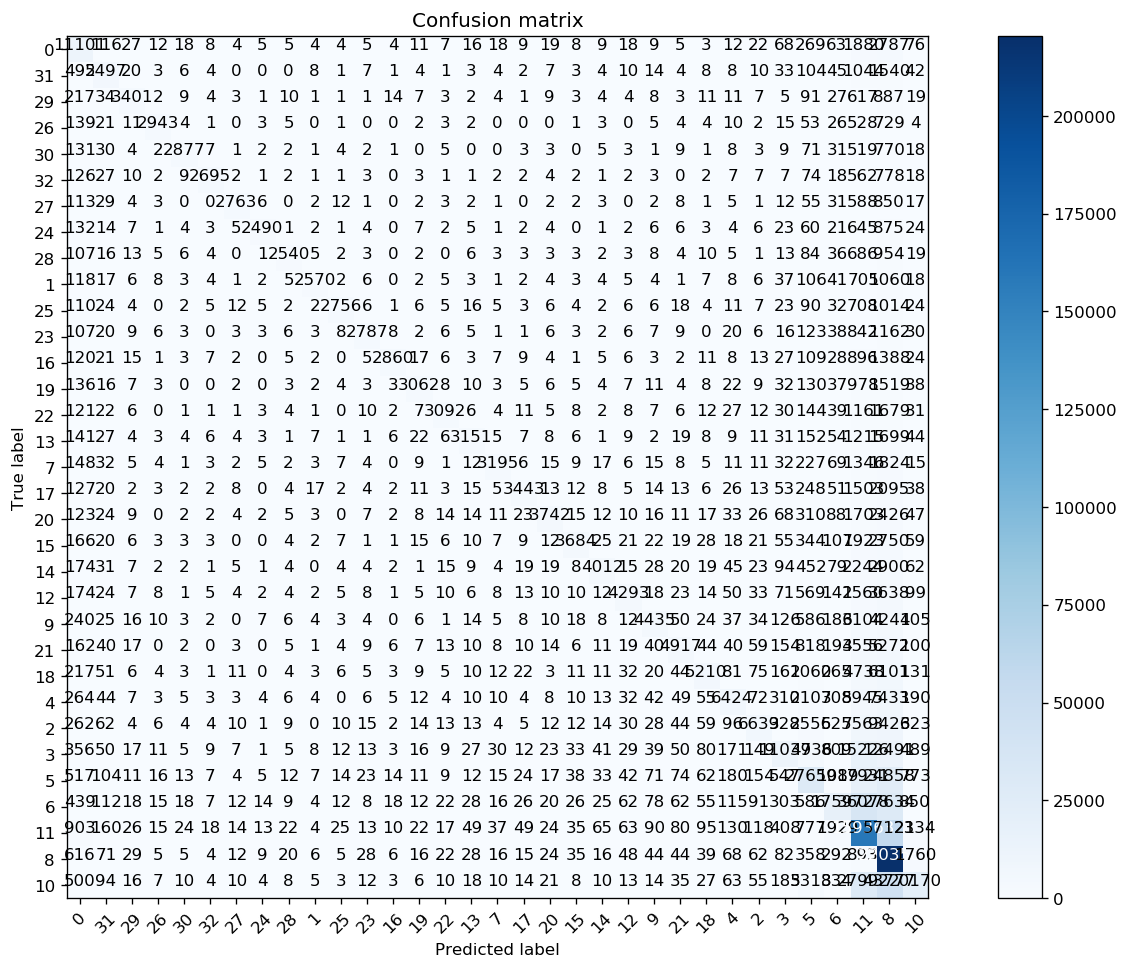

In [14]:
train_weight_dict =  (1/(train_y.value_counts()/train_y.count())).to_dict()
valid_weight_dict =  (1/(valid_y.value_counts()/valid_y.count())).to_dict()
dtrain = xgb.DMatrix(train_x,label=train_y,weight=train_y.map(train_weight_dict))
dvalid = xgb.DMatrix(valid_x,label=valid_y,weight=valid_y.map(valid_weight_dict))
dtest = xgb.DMatrix(test_x,label=test_y)

del train_x,train_y,valid_x,valid_y,test_x

params = {
            'booster':'gbtree',
            'tree_method':'gpu_hist',
            'objective':'multi:softprob',
            'num_class':33,
#             'scale_pos_weight': float(len(train_y)-sum(train_y))/float(sum(train_y)),
            'eval_metric': ['merror','mlogloss'],
            'gamma':0.,
            'max_depth':6,
            'alpha':0.5,
            'lambda':1.5,
            'subsample':0.7,
            'colsample_bytree':0.8,
            'min_child_weight':6, 
            'eta': 0.01,
            'seed':666,
            'silent':1,
            'missing':-1,
        }
# xgb_cv = xgb.cv(params, dtrain, 
#            num_boost_round=1000, 
#            nfold=3, stratified=True,#folds=sfk
#            metrics='auc', maximize=True, 
#            early_stopping_rounds=500, 
#            as_pandas=True, verbose_eval=1, 
#            show_stdv=False, seed=0, shuffle=True)

def custom_eval(preds, dtrain):
    labels = dtrain.get_label()
    
    prob_argmax = np.argmax(preds,axis=1)
    preds[prob_argmax==32] = 0.0
    
    pred_prob = [preds[i][int(labels[i])] for i in range(len(labels))]
    
    if dtrain!=dvalid:
        pred_amt = train_due_amt*pred_prob
        rmse = np.sqrt(mean_squared_error(train_repay_amt,pred_amt))
        
    else:
        pred_amt = valid_due_amt*pred_prob
        rmse = np.sqrt(mean_squared_error(valid_repay_amt,pred_amt))
    
    return "amt_rmse",rmse

xgb_model = xgb.train(params,dtrain,num_boost_round=10000,early_stopping_rounds=6000,
                       evals=[(dtrain,'train'),(dvalid,'valid')],verbose_eval=2,
                      feval=custom_eval)#xgb_model=xgb_trained_model)

y_pred_prob = xgb_model.predict(dtest,ntree_limit=xgb_model.best_ntree_limit)
y_pred = np.argmax(y_pred_prob,axis=1)

cm = confusion_matrix(test_y,y_pred)

eval_info(xgb_model,test_y,y_pred,y_pred_prob,cm)

# plt.figure(figsize=(20,20))
# xgb.plot_importance(xgb_model,max_num_features=20)
# xgb.plot_tree(xgb_model,ax=plt,num_trees=5)

# [9996]	train-mlogloss:1.41313	valid-mlogloss:1.47617	train-amt_rmse:363.674	valid-amt_rmse:369.743
# [9998]	train-mlogloss:1.41305	valid-mlogloss:1.47609	train-amt_rmse:363.663	valid-amt_rmse:369.732
# [9999]	train-mlogloss:1.41301	valid-mlogloss:1.47606	train-amt_rmse:363.659	valid-amt_rmse:369.727
                
# -----the best model eval info-----
#  RMSE:317.7691096787473
#  MAE:215.36765205592044
#  logloss:1.4733390009020164
#  accuracy:0.5616010474328614            

In [7]:
#  'attr',
#  'attributes',
#  'best_iteration',
#  'best_ntree_limit',
#  'best_score',
#  'boost',
#  'booster',
#  'copy',
#  'dump_model',
#  'eval',
#  'eval_set',
#  'feature_names',
#  'feature_types',
#  'get_dump',
#  'get_fscore',
#  'get_score',
#  'get_split_value_histogram',
#  'handle',
#  'load_model',
#  'load_rabit_checkpoint',
#  'predict',
#  'save_model',
#  'save_rabit_checkpoint',
#  'save_raw',
#  'set_attr',
#  'set_param',
#  'trees_to_dataframe',
#  'update'

# xgb_model.attributes()
# {'best_iteration': '4999',
#  'best_msg': '[4999]\ttrain-mlogloss:1.66371',
#  'best_score': '1.663713'}

# xgb_model.feature_names
# xgb_model.feature_types
# xgb_model.get_fscore()
# xgb_model.get_score()
# xgb_model.save_rabit_checkpoint()
# xgb_model.load_rabit_checkpoint()

### save

In [15]:
# save model
with open("../save_models/xgboost_10000.txt",'wb') as f:
    pickle.dump(xgb_model,f)

### predict

#### pred

In [11]:
test_set = pd.read_csv('./test_set.csv')
test_set.drop(['repay_amt','repay_audit_delta'],axis=1,inplace=True)
test_set.head()

,due_amt,auditing_date_month,auditing_date_days,auditing_date_dayofweek,due_date_month,due_date_dayofweek,listing_cat_1,listing_cat_2,listing_cat_3,listing_cat_4,...,repay_date_h_dayofweek,auditing_date_h_month,auditing_date_h_days,auditing_date_h_dayofweek,have_repay_h,age_1,age_2,age_3,age_4,age_5
0,138.5903,3,12,1,4,4,0,0,0,0,...,0.0,2.0,11.0,0.0,1.0,0,0,1,0,0
1,208.0805,3,15,4,4,0,0,0,0,0,...,4.0,1.0,15.0,1.0,1.0,0,1,0,0,0
2,208.0805,3,15,4,4,0,0,0,0,0,...,4.0,1.0,15.0,1.0,1.0,0,1,0,0,0
3,208.0805,3,15,4,4,0,0,0,0,0,...,4.0,1.0,15.0,1.0,1.0,0,1,0,0,0
4,208.0805,3,15,4,4,0,0,0,0,0,...,4.0,1.0,15.0,1.0,1.0,0,1,0,0,0


In [ ]:
with open("../save_models/xgboost_20000.txt",'rb') as model_f:
    xgb_model = pickle.load(model_f)

dtest_set = xgb.DMatrix(test_set)
pred = xgb_model.predict(dtest_set,ntree_limit=xgb_model.best_ntree_limit)
pred

In [17]:
sub_info = pd.read_csv('../data_preprocess/sub_info.csv')
sub_test = sub_info[sub_info['repay_amt'].isnull()][['user_id','listing_id','auditing_date','due_amt']]
sub_test = sub_test.reset_index(drop=True)
print(sub_test.shape)
sub_test.head()

(786845, 4)


,user_id,listing_id,auditing_date,due_amt
0,498765,5431438,2019-03-12,138.5903
1,34524,5443211,2019-03-15,208.0805
2,34524,5443211,2019-03-15,208.0805
3,34524,5443211,2019-03-15,208.0805
4,34524,5443211,2019-03-15,208.0805


In [33]:
prob_cols = ['prob_%s' % i for i in range(pred.shape[1])]
pred_df = pd.concat([sub_test,pd.DataFrame(pred,columns=prob_cols)],axis=1)

In [35]:
pred_df.to_csv('./pred_df.csv',index=False)

#### submission

In [58]:
pred_df = pd.read_csv('./pred_df.csv',parse_dates=['auditing_date'])
# pred_prob = np.load('./pred.npy')

In [59]:
pred_df.shape

(786845, 37)

In [60]:
pred_df = pred_df.drop_duplicates()
pred_df.shape

(786423, 37)

In [61]:
pred_df.head()

,user_id,listing_id,auditing_date,due_amt,prob_0,prob_1,prob_2,prob_3,prob_4,prob_5,...,prob_23,prob_24,prob_25,prob_26,prob_27,prob_28,prob_29,prob_30,prob_31,prob_32
0,498765,5431438,2019-03-12,138.5903,0.000723,0.000777,0.001216,0.000917,0.000949,0.000668,...,0.007458,0.006839,0.010468,0.028450,0.028225,0.091910,0.077290,0.131411,0.499633,0.075856
1,34524,5443211,2019-03-15,208.0805,0.001105,0.001095,0.000151,0.000634,0.000358,0.000638,...,0.001984,0.024127,0.015341,0.019141,0.016845,0.043183,0.046203,0.136614,0.580413,0.072587
2,34524,5443211,2019-03-15,208.0805,0.001441,0.001209,0.000192,0.000685,0.000426,0.000709,...,0.002186,0.024345,0.017489,0.022431,0.017492,0.043232,0.047356,0.133111,0.577992,0.069905
3,34524,5443211,2019-03-15,208.0805,0.001147,0.001162,0.000158,0.000772,0.000364,0.000690,...,0.001653,0.021669,0.013584,0.018452,0.017450,0.042041,0.049499,0.145880,0.580217,0.069824
4,34524,5443211,2019-03-15,208.0805,0.001390,0.001174,0.000176,0.000670,0.000433,0.000732,...,0.001949,0.021661,0.014865,0.017772,0.016303,0.044613,0.047502,0.137006,0.582056,0.070201


In [62]:
pred_df = pred_df.groupby(['user_id','listing_id','auditing_date','due_amt'])[prob_cols].mean().reset_index()

In [64]:
sub_example = pd.read_csv('../train_data/submission/submission.csv', parse_dates=['repay_date'])
sub_df = sub_example.merge(pred_df.drop('user_id',axis=1), on='listing_id', how='left')

In [65]:
sub_df.head()

,listing_id,repay_amt,repay_date,auditing_date,due_amt,prob_0,prob_1,prob_2,prob_3,prob_4,...,prob_23,prob_24,prob_25,prob_26,prob_27,prob_28,prob_29,prob_30,prob_31,prob_32
0,5431438,4.3309,2019-03-12,2019-03-12,138.5903,0.000723,0.000777,0.001216,0.000917,0.000949,...,0.007458,0.006839,0.010468,0.02845,0.028225,0.09191,0.07729,0.131411,0.499633,0.075856
1,5431438,4.3309,2019-03-13,2019-03-12,138.5903,0.000723,0.000777,0.001216,0.000917,0.000949,...,0.007458,0.006839,0.010468,0.02845,0.028225,0.09191,0.07729,0.131411,0.499633,0.075856
2,5431438,4.3309,2019-03-14,2019-03-12,138.5903,0.000723,0.000777,0.001216,0.000917,0.000949,...,0.007458,0.006839,0.010468,0.02845,0.028225,0.09191,0.07729,0.131411,0.499633,0.075856
3,5431438,4.3309,2019-03-15,2019-03-12,138.5903,0.000723,0.000777,0.001216,0.000917,0.000949,...,0.007458,0.006839,0.010468,0.02845,0.028225,0.09191,0.07729,0.131411,0.499633,0.075856
4,5431438,4.3309,2019-03-16,2019-03-12,138.5903,0.000723,0.000777,0.001216,0.000917,0.000949,...,0.007458,0.006839,0.010468,0.02845,0.028225,0.09191,0.07729,0.131411,0.499633,0.075856


In [67]:
sub_df['days'] = (sub_df['repay_date'] - sub_df['auditing_date']).dt.days
pred_prob = sub_df[prob_cols].values
pred_days = sub_df['days'].values
prob_someone_day = [pred_prob[i][pred_days[i]] for i in range(pred_prob.shape[0])]
sub_df['repay_amt'] = sub_df['due_amt'] * prob_someone_day


sub_df[['listing_id', 'repay_date', 'repay_amt']].to_csv('./predict_df.csv', index=False)

In [3]:
# pred_df['pred_days'] = pred_df['pred_days'].astype('int')

# (pred_df['pred_days']==32).value_counts(dropna=False)

# # pred_df[pred_df.duplicated(subset=['user_id','listing_id'],keep=False)].sort_values(['user_id','listing_id','pred_days'])

# from pandas.tseries.offsets import Day,DateOffset

# def generate_submission(sub_df):
#     sub_df['repay_date'] = sub_df['auditing_date']+sub_df['pred_days'].apply(lambda d: DateOffset(days=d))
#     sub_df = sub_df.rename(columns={'due_amt':'repay_amt'})
#     sub_df.loc[sub_df['pred_days']==32.0,['repay_amt','repay_date']] = None
#     sub_df = sub_df.drop(['user_id','auditing_date','pred_days'],axis=1)
#     return sub_df

# pred_df = pred_df.sort_values(['user_id','listing_id','pred_days'])

# # keep first
# pred_df_kfst = pred_df.drop_duplicates(subset=pred_df.columns.drop('pred_days'),keep='first')
# print(pred_df_kfst.shape)

# pred_df_kfst = generate_submission(pred_df_kfst)
# print(pred_df_kfst.shape)
# pred_df_kfst.head()

# # keep last
# pred_df = pred_df.sort_values(['user_id','listing_id','pred_days'])
# pred_df_klst = pred_df.drop_duplicates(subset=pred_df.columns.drop('pred_days'),keep='last')
# print(pred_df_klst.shape)
# pred_df_klst = generate_submission(pred_df_klst)
# print(pred_df_klst.shape)
# pred_df_klst.head()

# # mean
# pred_df_kmean = pred_df.copy()

# pred_df_kmean['repay_date'] = pred_df_kmean['auditing_date']+pred_df_kmean['pred_days'].apply(lambda d:DateOffset(days=d))
# pred_df_kmean = pred_df_kmean.rename(columns={'due_amt':'repay_amt'})
# pred_df_kmean['repay_amt'] = pred_df_kmean.groupby(['user_id','listing_id','pred_days'])\
#                             ['repay_amt'].mean().reset_index()['repay_amt']

# pred_df_kmean = pred_df_kmean.sort_values(['user_id','listing_id','pred_days'])
# pred_df_kmean = pred_df_kmean.drop_duplicates(subset=['user_id','listing_id'],keep='first')

# pred_df_kmean.loc[pred_df_kmean['pred_days']==32,['repay_amt','repay_date']] = None
# pred_df_kmean = pred_df_kmean.drop(['user_id','auditing_date','pred_days'],axis=1)

# print(pred_df_kmean.shape)
# pred_df_kmean.head()

# pred_df_kfst.to_csv('./pred_df_kfst.csv',index=False)
# pred_df_klst.to_csv('./pred_df_klst.csv',index=False)
# pred_df_kmean.to_csv('./pred_df_kmean.csv',index=False)

## lightgbm sklearn

In [5]:
from lightgbm import LGBMClassifier
# import lightgbm as lgb

In [1]:
params = {
            'boosting_type':'gbdt',
            'device_type':'gpu',
            'objective':'multiclass',
            'num_class':33,
            'n_estimators':20000,#'num_iterations' 
            'metric': 'multi_logloss',
#             'min_gain_to_split':0. #'gamma'
            'max_depth':6,
            'reg_alpha':2, #'lambda_l1':0.5,
            'reg_lambda':3,#'lambda_l2':1.5, 
            'subsample':0.7,#'bagging_fraction':0.7
            'colsample_bytree':0.8,
#             'num_leaves':31,
            'learning_rate': 0.05, #eta
            'random_state':666,
            'missing':-1,
#             'early_stopping_round':
        }

lgb_model = LGBMClassifier().set_params(params)

def custom_eval(y_true,y_pred):
    
    prob_argmax = np.argmax(y_pred,axis=1)
    y_pred[prob_argmax==32] = 0.0
    
    pred_prob = [y_pred[i][int(y_true[i])] for i in range(len(y_true))]
    
    if y_true.shape[0]==train_due_amt.shape[0]:
        pred_amt = train_due_amt*pred_prob
        rmse = np.sqrt(mean_squared_error(train_repay_amt,pred_amt))
        
    else:
        pred_amt = valid_due_amt*pred_prob
        rmse = np.sqrt(mean_squared_error(valid_repay_amt,pred_amt))
    
    return "amt_rmse",rmse,False #is_higher_better

lgb_model.fit(train_x,train_y,
              eval_set=[(train_x,train_y),(valid_x,valid_y)],
              eval_metric=custom_eval,
              early_stopping_rounds=12000,
              verbose=2)

# y_pred_prob = lgb_model.predict_proba(test_x,num_iteration=lgb_model.best_iteration_)
# y_pred = np.argmax(y_pred_prob,axis=1)

# cm = confusion_matrix(test_y,y_pred)

# eval_info(lgb_model,test_y,y_pred,y_pred_prob,cm)

## lightgbm

In [13]:
import lightgbm as lgb

### train

In [15]:
dtrain = lgb.Dataset(train_x,label=train_y) # free_raw_data=True
dvalid = lgb.Dataset(valid_x,label=valid_y)
# dtest = lgb.Dataset(test_x,label=test_y)

params = {
            'boosting':'gbdt',
#             'device_type':'gpu',
            'objective':'multiclass',
            'num_class':33,
#             'num_iterations':100,
            'metric': 'multi_logloss',
#             'min_gain_to_split':0. #'gamma'
            'max_depth':6,
            'lambda_l1':2, #'alpha'
            'lambda_l2':3, # 'lambda'
            'bagging_fraction':0.7,#'subsample'
            'feature_fraction':0.8,#'colsample_bytree'
#             'num_leaves':31,
            'learning_rate': 0.05, #eta
            'seed':666,
            'silent':1,
            'missing':-1,
#             'early_stopping_round':
        }
# lgb.cv（params，train_set，num_boost_round = 100，
#             folds = None，nfold = 5，stratified = True，shuffle = True，
#             metrics = None，fobj = None，feval = None，init_model = None，
#             feature_name ='auto'，categorical_feature =' auto'，early_stopping_rounds = None，
#             fpreproc = None，verbose_eval = None，show_stdv = True，seed = 0，callbacks = None，
#             eval_train_metric = False ）

def custom_eval(preds, dtrain):
    labels = dtrain.get_label()
    
    prob_argmax = np.argmax(preds,axis=1)
    preds[prob_argmax==32] = 0.0
    
    pred_prob = [preds[i][int(labels[i])] for i in range(len(labels))]
    
    if dtrain!=dvalid:
        pred_amt = train_due_amt*pred_prob
        rmse = np.sqrt(mean_squared_error(train_repay_amt,pred_amt))
        
    else:
        pred_amt = valid_due_amt*pred_prob
        rmse = np.sqrt(mean_squared_error(valid_repay_amt,pred_amt))
    
    return "amt_rmse",rmse,False #is_higher_better

lgb_model = lgb.train(params,dtrain,num_boost_round=20000,valid_sets=dvalid,
                      early_stopping_rounds=12000,keep_training_booster = True,
                      verbose_eval=2,
                      feval=custom_eval)#init_model=lgb_trained_model)

# y_pred_prob = lgb_model.predict(dtest,ntree_limit=lgb_model.best_ntree_limit)
# y_pred = np.argmax(y_pred_prob,axis=1)

# cm = confusion_matrix(test_y,y_pred)

# eval_info(xgb_model,test_y,y_pred,y_pred_prob,cm)

MemoryError: 

### save

## GBDT

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.multiclass import OneVsOneAllClassifier

### train

In [ ]:
param_grid = {
#         'loss':['deviance'],
        'n_estimators':[145,100,80],
        'max_depth':[4,3,5],
        'learning_rate':[0.03,0.01],
#         'criterion':['friedman_mse'],#默认
        'subsample': [0.8],
        'max_features':[0.7],
#         "max_leaf_nodes":[8],
#         'min_impurity_decrease':[0],
        'random_state':[666],
}

GBDT = GridSearchCV(OneVsOneAllClassifier(GradientBoostingRegressor().set_params(*param_grid)),cv=sfk,scoring='neg_log_loss')
GBDT.fit(train_x,train_y)

print(" best score: %f \n best model: %s" % (GBDT.best_score_, GBDT.best_estimator_))


GBDT_best = GBDT.best_estimator_
y_pred =GBDT_best.predict(test_x)

y_pred_prob = GBDT_best.predict_proba(test_x)

train_score = GBDT_best.score(train_x,train_y)
test_score = GBDT_best.score(test_x,test_y)

cm = confusion_matrix(test_y,y_pred)

eval_info(GBDT_best,test_y,y_pred,y_pred_prob,cm)
print( "train_score:",train_score,"\n","test_score:",test_score)

### save

In [ ]:
# save model
with open("../save_models/GBDT.txt",'wb') as f:
    pickle.dump(GBDT_best,f)

### predict

In [89]:
# predict
test_all = pd.read_csv("./another data/test_all_clean.csv",index_col=['cust_group','cust_id'])
y_pred = GBDT_best.predict(test_all)
y_pred_prob = GBDT_best.predict_proba(test_all)[:,1]

print(pd.Series(y_pred).value_counts())
pred_result = pd.Series(y_pred_prob,index=test_all.index.get_level_values(level=1),name="pred_prob")
pred_result.index.name = "cust_id"
pred_result.sort_index().to_csv("./predict/pred_result_GBDT.csv",header=True)

0    9995
1       5
dtype: int64


## MLP

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV

### train

In [ ]:
param_grid = {
    'hidden_layer_sizes':[(300,),(100,),(200,)],
    'activation':['logistic','relu'],
#     'solver':['adam'],
#     'Note':
    'alpha':[0.012,0.05],
#     'batch_size':
    'learning_rate':['constant',0.01],
#     'learning_rate_init':
#     'power_t':
#     'max_iter':
#     'shuffle':
    'random_state':[666],
#     'tol':
#     'verbose':
#     'warm_start':
#     'momentum':[0.9,0.7],
#     'nesterovs_momentum':
#     'early_stopping':
#     'validation_fraction':
#     'beta_1':
#     'beta_2':
#     'epsilon':
}

MLP = GridSearchCV(MLPRegressor(),param_grid,cv=sfk,scoring='neg_mean_squared_error')
MLP.fit(train_x,train_y)

print(" best score: %f \n best model: %s" % (MLP.best_score_, MLP.best_estimator_))


MLP_best = MLP.best_estimator_
y_pred =MLP_best.predict(test_x)

model_score = MLP_best.score(test_x,test_y)

eval_info(MLP_best,test_y,y_pred)

print("model_score:",model_score)

### save

In [ ]:
# save model
with open("../save_models/MLP.txt",'wb') as f:
    pickle.dump(MLP_best,f)

# cross-validation
from sklearn.cross_validation import cross_val_score
MLP_cv_mse = cross_val_score(MLP_best,X,y,cv=5,scoring="neg_mean_squared_error")
print("mse",MLP_cv_mse)

### predict

In [92]:
# predict
test_all = pd.read_csv("./another data/test_all_clean.csv",index_col=['cust_group','cust_id'])
y_pred = MLP_best.predict(test_all)
y_pred_prob = MLP_best.predict_proba(test_all)[:,1]

print(pd.Series(y_pred).value_counts())
pred_result = pd.Series(y_pred_prob,index=test_all.index.get_level_values(level=1),name="pred_prob")
pred_result.index.name = "cust_id"
pred_result.sort_index().to_csv("./predict/pred_result_MLP.csv",header=True)

0    10000
dtype: int64


## adaboost

### train

best score: 0.797058 
 best model: AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=4, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=140, n_jobs=1, oob_score=False, random_state=222,
            verbose=0, warm_start=False),
          learning_rate=0.05, n_estimators=270, random_state=999)
------AdaBoostClassifier classification_report------
              precision    recall  f1-score   support

          0       0.98      0.83      0.90      3541
          1       0.15      0.62      0.24       172

avg / total       0.94      0.82      0.87      3713

auc: 0.8046669249916264
train_score: 0.8442475757212977 
 test_score: 0.8168596821976838


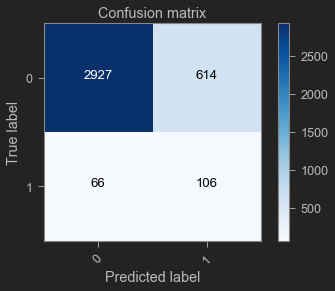

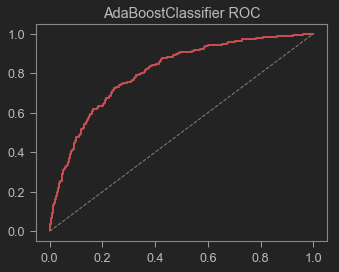

In [141]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'base_estimator':[RF_best],
    'n_estimators':[270],
    'learning_rate':[0.05],
    'random_state':[999],
}

ADAB = GridSearchCV(AdaBoostClassifier(),param_grid,cv=sfk,scoring="roc_auc")
ADAB.fit(train_x,train_y)

print("best score: %f \n best model: %s" % (ADAB.best_score_,ADAB.best_estimator_))

ADAB_best = ADAB.best_estimator_
train_score = ADAB_best.score(train_x,train_y)
test_score = ADAB_best.score(test_x,test_y)
y_pred = ADAB_best.predict(test_x)
y_pred_prob = ADAB_best.predict_proba(test_x)[:,1]
cm = confusion_matrix(test_y,y_pred)

eval_info(ADAB_best,test_y,y_pred_prob,cm)
print("train_score:",train_score,"\n","test_score:",test_score)

### save

In [142]:
# save model
import pickle
with open("./best_models/ADAB_RF_pkl.txt",'wb') as f:
    pickle.dump(ADAB_best,f)

# cross-validation
from sklearn.cross_validation import cross_val_score
ADAB_cv_auc = cross_val_score(ADAB_best,X,y,cv=5,scoring="roc_auc")
print("best_ADAB_cv_auc:",ADAB_cv_auc)

best_ADAB_cv_auc: [0.8104355  0.82646391 0.82957119 0.7907972  0.81782743]


### predict

In [143]:
# predict
test_all = pd.read_csv("./another data/test_all_clean.csv",index_col=['cust_group','cust_id'])
y_pred = ADAB_best.predict(test_all)
y_pred_prob = ADAB_best.predict_proba(test_all)[:,1]

print(pd.Series(y_pred).value_counts())
pred_result = pd.Series(y_pred_prob,index=test_all.index.get_level_values(level=1),name="pred_prob")
pred_result.index.name = "cust_id"
pred_result.sort_index().to_csv("./predict/pred_result_ADAB_RF.csv",header=True)

0    9448
1     552
dtype: int64


## SVM

In [ ]:
# svm_train_xy = pd.read_csv("F:./resample data/under_resample1.csv",index_col=['cust_id'])
# svm_y = svm_train_xy.y
# svm_X = svm_train_xy.drop('y',axis=1)
# svm_train_x,svm_test_x,svm_train_y,svm_test_y = train_test_split(svm_X,svm_y,stratify=svm_y)
# sfk = StratifiedKFold(n_splits=3)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

### train

In [ ]:
param_grid = {
            'C':[0.5,0.1,1],
            'kernel':['rbf'],
#             'class_weight':["balanced"],
            'gamma':[0.03,0.01,0.1],
#             'shrinking':[True],
             }
# SVR(C=0.5, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.03,
#   kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

SVR = GridSearchCV(SVR(),param_grid,cv=sfk,scoring='neg_mean_squared_error')
SVR.fit(train_x,train_y)

print(" best score: %f \n best model: %s" % (SVR.best_score_, SVR.best_estimator_))


SVR_best = SVR.best_estimator_
y_pred =SVR_best.predict(test_x)

model_score = SVR_best.score(test_x,test_y)

eval_info(SVR_best,test_y,y_pred)

print("model_score:",model_score)

### save 

In [ ]:
# save model
with open("../save_models/SVR.txt",'wb') as f:
    pickle.dump(SVR_best,f)

# cross-validation
from sklearn.cross_validation import cross_val_score
SVR_cv_mse = cross_val_score(SVR_best,X,y,cv=5,scoring="neg_mean_squared_error")
print("mse",SVR_cv_mse)

### predict

# bagging xgb_best

In [ ]:
from sklearn.ensemble import BaggingRegressor

## train

In [ ]:
bagging_xgb = BaggingRegressor(XGBR_best,n_estimators=10)

bagging_xgb.fit(train_x,train_y)
y_pred = bagging_xgb.predict(test_x)

model_score = bagging_xgb.score(test_x,test_y)
eval_info(bagging_xgb,test_y,y_pred)

print("model score: ",model_score)

## save

In [ ]:
# save model
with open("../save_models/bagging_xgb.txt",'wb') as f:
    pickle.dump(bagging_xgb,f)

# cross-validation
from sklearn.cross_validation import cross_val_score
bagging_xgb_cv_mse = cross_val_score(bagging_xgb_best,X,y,cv=5,scoring="neg_mean_squared_error")
print("mse",bagging_xgb_cv_mse)

## predict

# bagging xgb:sklearn(vary params)

In [ ]:
n_estimators = [142,145,148] 
max_depth = [2,3,4] 
learning_rate = np.linspace(0.045,0.055,10) 
min_child_weight= [5,4,6] 
gamma = np.linspace(0.045,0.055,10)
subsample = [0.7,0.75,0.8,0.85]
colsample_bytree = [0.6,0.65,0.7,0.75]
reg_alpha =[6,7,8]
reg_lambda = [4,5,6]
random_state = np.arange(1000,10000,100)

np.random.shuffle(n_estimators)
np.random.shuffle(max_depth)
np.random.shuffle(learning_rate)
np.random.shuffle(min_child_weight)
np.random.shuffle(gamma)
np.random.shuffle(subsample)
np.random.shuffle(colsample_bytree)
np.random.shuffle(reg_alpha)
np.random.shuffle(reg_lambda)
np.random.shuffle(random_state)

prob_df = pd.DataFrame([],index=test_x.index)
for i in range(30):
    param_grid = {
        'booster':'gbtree',
        'objective': 'reg:linear',
        'n_estimators':n_estimators[i%3],
        'max_depth':max_depth[i%3],
        'learning_rate':learning_rate[i%10],
        'min_child_weight':min_child_weight[i%3],
        'gamma':gamma[i%10],
        'subsample':subsample[i%4],
        'colsample_bytree': colsample_bytree[i%4],
        'reg_alpha':reg_alpha[i%3],
        'reg_lambda': reg_lambda[i%3],
#         'scale_pos_weight':float(len(train_y)-sum(train_y))/float(sum(train_y)),
        'random_state':random_state[i],
#     'n_jobs': [-1],
        'missing': -1,
        'silent':True,
    }

#     bagging_xgb = BaggingClassifier(XGBClassifier().set_params(**param_grid),n_estimators=10)
    # bagging_xgb = BaggingClassifier(XGB_best,n_estimators=10)
#     bagging_xgb.fit(train_x,train_y)
    xgb_ = XGBClassifier().set_params(**param_grid)
    xgb_.fit(train_x,train_y)
    y_pred = xgb_.predict(test_x)
    y_prob_s = pd.Series(y_pred,index=test_x.index)
    prob_df = pd.concat([prob_df,y_prob_s],axis=1)

y_pred_mean = prob_df.mean(axis=1)
eval_info(xgb_,test_y,y_pred_mean)


# xgb+lr

[0]	train-auc:0.75003
Will train until train-auc hasn't improved in 304 rounds.
[20]	train-auc:0.825611
[40]	train-auc:0.833463
[60]	train-auc:0.837016
[80]	train-auc:0.840613
[100]	train-auc:0.843919
[120]	train-auc:0.84783
[140]	train-auc:0.851898
[160]	train-auc:0.855635
[180]	train-auc:0.859144
[200]	train-auc:0.862247
[220]	train-auc:0.866045
[240]	train-auc:0.868845
[260]	train-auc:0.871496
[280]	train-auc:0.874424
[300]	train-auc:0.87775
[320]	train-auc:0.880032
[340]	train-auc:0.883009
[360]	train-auc:0.885558
[380]	train-auc:0.888023
[400]	train-auc:0.890347
[420]	train-auc:0.892764
[440]	train-auc:0.895291
[460]	train-auc:0.897798
[480]	train-auc:0.90019
[499]	train-auc:0.90214
best score: 0.899969 
 best model: LogisticRegression(C=0.06, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=80,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=666,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)
--

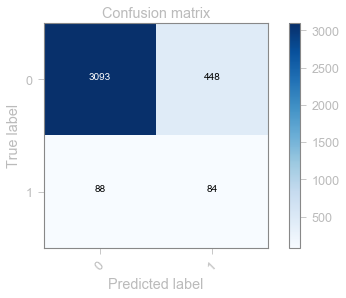

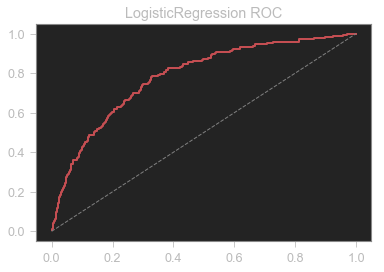

In [133]:
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder

dtrain = xgb.DMatrix(train_x,label=train_y)
dtest = xgb.DMatrix(test_x)
one_hot = OneHotEncoder()

params = {
            'booster':'gbtree',
            'objective': 'binary:logistic',
            'scale_pos_weight': float(len(train_y)-sum(train_y))/float(sum(train_y)),
            'eval_metric': 'auc',
            'gamma':0.05,
            'max_depth':3,
            'alpha':7,
            'lambda':5,
            'subsample':0.8,
            'colsample_bytree':0.6,
            'min_child_weight':5, 
            'eta': 0.02,
            'seed':0,
            'silent':1,
            'missing':-1,
        }

xgb_model = xgb.train(params,dtrain,num_boost_round=500,early_stopping_rounds=304,
                       evals=[(dtrain,"train")],verbose_eval=20,maximize=True)

train_leaf = xgb_model.predict(dtrain,ntree_limit=304,pred_leaf=True)
test_leaf = xgb_model.predict(dtest,ntree_limit=304,pred_leaf=True)

train_leaf_hot = one_hot.fit_transform(train_leaf)
test_leaf_hot = one_hot.transform(test_leaf)
     

param_grid =  {
            'penalty':['l2'],
            'C':[0.06],
            'solver':['lbfgs'],#['newton-cg','sag'],#l2
#             'solver':['liblinear'],#,'saga',],#l1
            'max_iter':[80],
            'class_weight':['balanced'],
#             'fit_intercept':[True],
            'random_state':[666],      
}

xgbLR = GridSearchCV(LogisticRegression(),param_grid,cv=sfk,scoring='roc_auc')
xgbLR.fit(train_leaf_hot,train_y)

print("best score: %f \n best model: %s" % (xgbLR.best_score_,xgbLR.best_estimator_))
xgbLR_best = xgbLR.best_estimator_

train_score = xgbLR_best.score(train_leaf_hot,train_y)
test_score = xgbLR_best.score(test_leaf_hot,test_y)
y_pred = xgbLR_best.predict(test_leaf_hot)
y_pred_prob = xgbLR_best.predict_proba(test_leaf_hot)[:,1]
cm = confusion_matrix(test_y,y_pred)

eval_info(xgbLR_best,test_y,y_pred_prob,cm)
print( "train_score:",train_score,"\n","test_score:",test_score)

# bagging dt

best score: 0.789294 
 best model: BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=4,
            max_features=0.8, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.04, presort=False, random_state=233,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=0.7,
         max_samples=0.8, n_estimators=80, n_jobs=1, oob_score=False,
         random_state=777, verbose=0, warm_start=False)
------BaggingClassifier classification_report------
              precision    recall  f1-score   support

          0       0.98      0.69      0.81      3541
          1       0.11      0.76      0.19       172

avg / total       0.94      0.70      0.79      3713

auc: 0.794160432935119
train_score: 0.7131569495989465 
 test_score: 0.6978184756261783


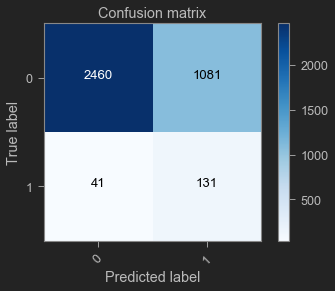

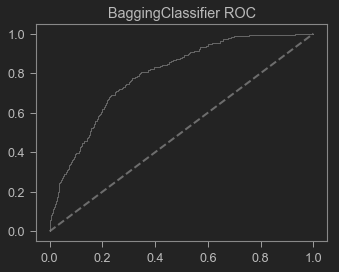

In [110]:
from sklearn.ensemble import BaggingClassifier
param_grid = {
    'base_estimator':[DT_best],#LR_best,SVC_best,GBDT_best],
    'n_estimators':[80],
    'max_samples':[0.8],
    'max_features':[0.7],
    'random_state':[777],
}

BAGG = GridSearchCV(BaggingClassifier(),param_grid,cv=sfk,scoring="roc_auc")
BAGG.fit(train_x,train_y)

print("best score: %f \n best model: %s" % (BAGG.best_score_,BAGG.best_estimator_))
BAGG_best = BAGG.best_estimator_
train_score = BAGG_best.score(train_x,train_y)
test_score = BAGG_best.score(test_x,test_y)
y_pred = BAGG_best.predict(test_x)
y_pred_prob = BAGG_best.predict_proba(test_x)[:,1]
cm = confusion_matrix(test_y,y_pred)

eval_info(BAGG_best,test_y,y_pred_prob,cm)
print("train_score:",train_score,"\n","test_score:",test_score)

# bagging lr

F:\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
F:\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
F:\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
F:\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
F:\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


best score: 0.801813 
 best model: BaggingClassifier(base_estimator=LogisticRegression(C=0.035, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=350,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=666,
          solver='saga', tol=0.0001, verbose=0, warm_start=False),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=10, n_jobs=1, oob_score=False,
         random_state=777, verbose=0, warm_start=False)
------BaggingClassifier classification_report------
              precision    recall  f1-score   support

          0       0.99      0.73      0.84      3541
          1       0.12      0.77      0.21       172

avg / total       0.95      0.73      0.81      3713

auc: 0.8116696111333679
train_score: 0.7323576943796014 
 test_score: 0.7322919472124967


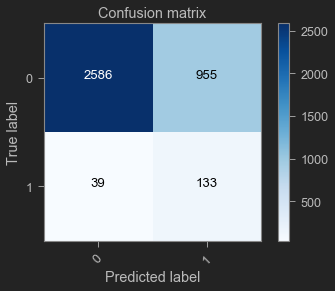

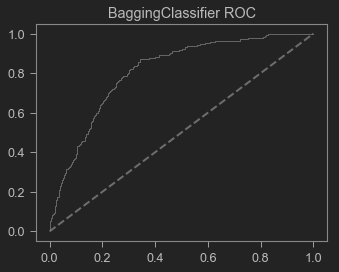

In [96]:
from sklearn.ensemble import BaggingClassifier
param_grid = {
    'base_estimator':[LR_best],#SVC_best,GBDT_best],
#     'n_estimators':[80],
#     'max_samples':[0.8],
#     'max_features':[0.7],
    'random_state':[777],
}

BAGG = GridSearchCV(BaggingClassifier(),param_grid,cv=sfk,scoring="roc_auc")
BAGG.fit(train_x,train_y)

print("best score: %f \n best model: %s" % (BAGG.best_score_,BAGG.best_estimator_))
BAGG_best = BAGG.best_estimator_
train_score = BAGG_best.score(train_x,train_y)
test_score = BAGG_best.score(test_x,test_y)
y_pred = BAGG_best.predict(test_x)
y_pred_prob = BAGG_best.predict_proba(test_x)[:,1]
cm = confusion_matrix(test_y,y_pred)

eval_info(BAGG_best,test_y,y_pred_prob,cm)
print("train_score:",train_score,"\n","test_score:",test_score)

# voting 

F:\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
F:\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
F:\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
F:\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


best score: 0.810093 
 best model: VotingClassifier(estimators=[('lr', LogisticRegression(C=0.035, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=350,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=666,
          solver='saga', tol=0.0001, verbose=0, warm_start=False)), ('mlp', MLPC...         presort='auto', random_state=1, subsample=0.8, verbose=0,
              warm_start=False))],
         flatten_transform=None, n_jobs=1, voting='soft',
         weights=[2, 5, 1, 1, 6, 5])


F:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
F:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
F:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


------VotingClassifier classification_report------
              precision    recall  f1-score   support

          0       0.96      0.98      0.97      3541
          1       0.26      0.12      0.17       172

avg / total       0.93      0.94      0.93      3713

auc: 0.8318320931546075
train_score: 0.9525947207757227 
 test_score: 0.9429033126851603


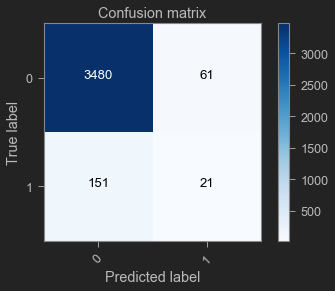

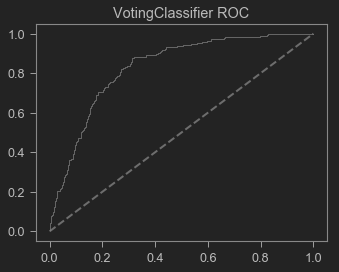

In [97]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier
param_grid ={
    'voting':['soft'],
    'weights':[
               [2,5,1,1,6,5],
    ]
}

estimators = [ ('lr', LR_best),('mlp',MLP_best), 
               ('rf', RF_best),('et', ET_best) ,
               ('xgb',XGB_best),('gbdt',GBDT_best)
             ]

voting =GridSearchCV(VotingClassifier(estimators),param_grid,cv=sfk,scoring="roc_auc")
voting.fit(train_x,train_y)

print("best score: %f \n best model: %s" % (voting.best_score_,voting.best_estimator_))
voting_best = voting.best_estimator_
train_score = voting_best.score(train_x,train_y)
test_score = voting_best.score(test_x,test_y)
y_pred = voting_best.predict(test_x)
y_pred_prob = voting_best.predict_proba(test_x)[:,1]
cm = confusion_matrix(test_y,y_pred)

eval_info(voting_best,test_y,y_pred_prob,cm)
print("train_score:",train_score,"\n","test_score:",test_score)

In [98]:
# save model
import pickle
with open("./best_models/voting_pkl.txt",'wb') as f:
    pickle.dump(voting_best,f)

# cross-validation
from sklearn.cross_validation import cross_val_score
voting_cv_auc = cross_val_score(voting_best,X,y,cv=5,scoring="roc_auc")
print("best_voting_cv_auc:",voting_cv_auc)

F:\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
F:\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
F:\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
F:\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
F:\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


best_voting_cv_auc: [0.81424925 0.83561827 0.82768003 0.80047202 0.82719307]


In [99]:
# predict
test_all = pd.read_csv("./another data/test_all_clean.csv",index_col=['cust_group','cust_id'])
y_pred = voting_best.predict(test_all)
y_pred_prob = voting_best.predict_proba(test_all)[:,1]

print(pd.Series(y_pred).value_counts())
pred_result = pd.Series(y_pred_prob,index=test_all.index.get_level_values(level=1),name="pred_prob")
pred_result.index.name = "cust_id"
pred_result.sort_index().to_csv("./predict/pred_result_voting.csv",header=True)

F:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0    9969
1      31
dtype: int64


best score: 0.810510 
 best model: VotingClassifier(estimators=[('xgb', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0.05, learning_rate=0.05,
       max_delta_step=0, max_depth=3, min_child_weight=5, missing=-1,
       n_estimators=145, n_jobs=1, nthread=None,
       objective='binary:logist...         presort='auto', random_state=1, subsample=0.8, verbose=0,
              warm_start=False))],
         flatten_transform=None, n_jobs=1, voting='soft',
         weights=[1, 2, 4, 4])


F:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
F:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
F:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


------VotingClassifier classification_report------
              precision    recall  f1-score   support

          0       0.96      0.99      0.98      3541
          1       0.41      0.08      0.14       172

avg / total       0.93      0.95      0.94      3713

auc: 0.8195572791814163
train_score: 0.9562758125336686 
 test_score: 0.952060328575276


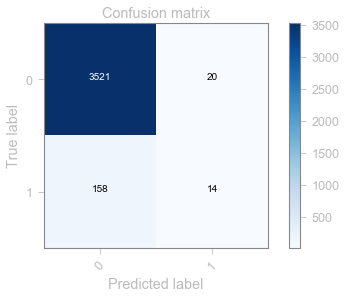

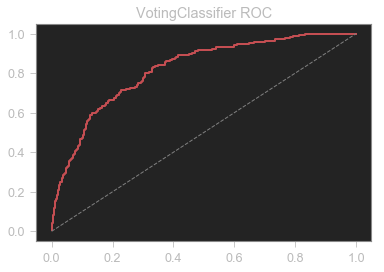

In [154]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier
param_grid ={
    'voting':['soft'],
    'weights':[
               [1,2,4,4],
    ]
}

estimators = [ ('xgb', XGB_best),('bagging_xgb', bagging_xgb),
              ('mlp',MLP_best),('gbdt',GBDT_best)
             ]

voting =GridSearchCV(VotingClassifier(estimators),param_grid,cv=sfk,scoring="roc_auc")
voting.fit(train_x,train_y)

print("best score: %f \n best model: %s" % (voting.best_score_,voting.best_estimator_))
voting_best = voting.best_estimator_
train_score = voting_best.score(train_x,train_y)
test_score = voting_best.score(test_x,test_y)
y_pred = voting_best.predict(test_x)
y_pred_prob = voting_best.predict_proba(test_x)[:,1]
cm = confusion_matrix(test_y,y_pred)

eval_info(voting_best,test_y,y_pred_prob,cm)
print("train_score:",train_score,"\n","test_score:",test_score)

# GBDT+LR

F:\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


------LogisticRegression classification_report------
              precision    recall  f1-score   support

          0       0.98      0.63      0.77      3541
          1       0.09      0.70      0.15       172

avg / total       0.94      0.64      0.74      3713

auc: 0.7218874578853695
train_score: 0.9525947207757227 
 test_score: 0.9429033126851603


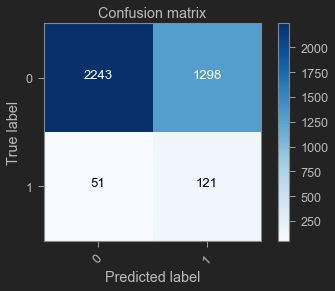

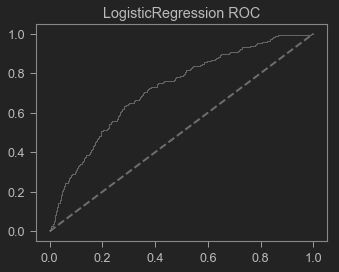

In [100]:
train_x,test_x,train_y,test_y = train_test_split(X,y,stratify=y)
train_x,train_x_lr,train_y,test_y_lr = train_test_split(train_x,train_y,stratify=train_y)

from sklearn.preprocessing import OneHotEncoder
one_hot = OneHotEncoder()

GBDT_best.fit(train_x,train_y)
one_hot.fit(GBDT_best.apply(train_x)[:,:,0])
LR_best.fit(one_hot.transform(GBDT_best.apply(train_x_lr)[:,:,0]),test_y_lr)

y_pred = LR_best.predict(one_hot.transform(GBDT_best.apply(test_x)[:,:,0]))
y_pred_prob = LR_best.predict_proba(one_hot.transform(GBDT_best.apply(test_x)[:,:,0]))[:,1]
cm = confusion_matrix(test_y,y_pred)

eval_info(LR_best,test_y,y_pred_prob,cm)
print( "train_score:",train_score,"\n","test_score:",test_score)

In [ ]:
GBDT_best.apply(train_x)[:,:,0]

best score: 0.795128 
 best model: LogisticRegression(C=0.06, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=50,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=666,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
------LogisticRegression classification_report------
              precision    recall  f1-score   support

          0       0.98      0.74      0.84      3541
          1       0.12      0.72      0.20       172

avg / total       0.94      0.74      0.81      3713

auc: 0.7910523239394994
train_score: 0.7651705565529623 
 test_score: 0.7368704551575546


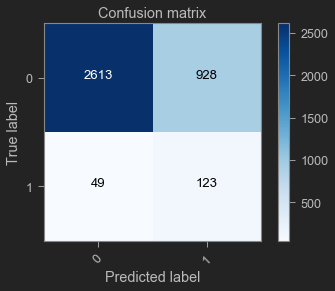

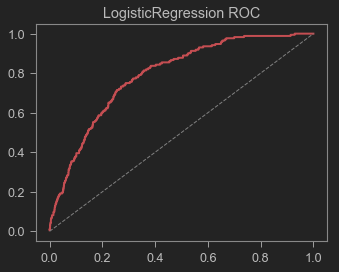

In [175]:
train_x,test_x,train_y,test_y = train_test_split(X,y,stratify=y)
train_x,train_x_lr,train_y,train_y_lr = train_test_split(train_x,train_y,stratify=train_y)

from sklearn.preprocessing import OneHotEncoder
one_hot = OneHotEncoder()

GBDT_best.fit(train_x,train_y)
one_hot.fit(GBDT_best.apply(train_x)[:,:,0])
train_x_lr = one_hot.transform(GBDT_best.apply(train_x_lr)[:,:,0])
test_x_lr = one_hot.transform(GBDT_best.apply(test_x)[:,:,0])
                               
param_grid =  {
            'penalty':['l1'],#'l2'],
            'C':[0.06],
#             'solver':['newton-cg','lbfgs','sag'],#l2
            'solver':['liblinear'],#,'saga',],#l1
            'max_iter':[50],
            'class_weight':['balanced'],
#             'fit_intercept':[True],
            'random_state':[666],      
}

GBLR = GridSearchCV(LogisticRegression(),param_grid,cv=sfk,scoring='roc_auc')
GBLR.fit(train_x_lr,train_y_lr)

print("best score: %f \n best model: %s" % (GBLR.best_score_, GBLR.best_estimator_))
GBLR_best = GBLR.best_estimator_

train_score = GBLR_best.score(train_x_lr,train_y_lr)
test_score = GBLR_best.score(test_x_lr,test_y)
y_pred = GBLR_best.predict(test_x_lr)
y_pred_prob = GBLR_best.predict_proba(test_x_lr)[:,1]
cm = confusion_matrix(test_y,y_pred)

eval_info(GBLR_best,test_y,y_pred_prob,cm)
print( "train_score:",train_score,"\n","test_score:",test_score)

# FM

In [ ]:
# from fastFM import sgd
# fm = sgd.FMClassification(n_iter=1000, init_stdev=0.1, l2_reg_w=0,
#                               l2_reg_V=0, rank=2, step_size=0.1)
# fm.fit(train_x,train_y)
# y_pred = fm.predict(test_x)
# y_pred_prob = fm.predict_proba(test_x)

# cm = confusion_matrix(test_y,y_pred)

# eval_info(fm,test_y,y_pred_prob,cm)
# print( "train_score:",train_score,"\n","test_score:",test_score)


# LDA

F:\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
F:\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
F:\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
F:\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
F:\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
F:\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
F:\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear


best score: 0.779201 
 best model: QuadraticDiscriminantAnalysis(priors=2, reg_param=0.911,
               store_covariance=False, store_covariances=None, tol=0.0001)
------QuadraticDiscriminantAnalysis classification_report------
              precision    recall  f1-score   support

          0       0.98      0.71      0.83      3541
          1       0.11      0.74      0.19       172

avg / total       0.94      0.71      0.80      3713

auc: 0.7943213387362655
train_score: 0.7164661519123721 
 test_score: 0.713977915432265


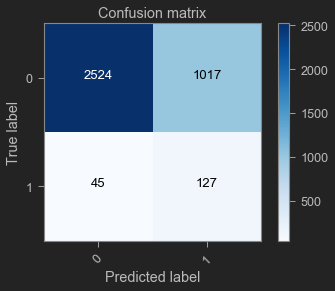

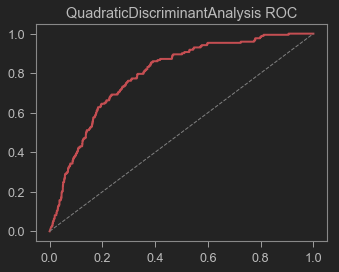

In [201]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV

param_grid = {
    'priors':[2], 
    'reg_param':[0.911],
#     'tol':[0.0001]
}


LDA = GridSearchCV(QuadraticDiscriminantAnalysis(),param_grid,cv=sfk,scoring='roc_auc')
LDA.fit(train_x,train_y)

print("best score: %f \n best model: %s" % (LDA.best_score_, LDA.best_estimator_))

LDA_best = LDA.best_estimator_
train_score = LDA_best.score(train_x,train_y)
test_score = LDA_best.score(test_x,test_y)
y_pred = LDA_best.predict(test_x)
y_pred_prob = LDA_best.predict_proba(test_x)[:,1]
cm = confusion_matrix(test_y,y_pred)

eval_info(LDA_best,test_y,y_pred_prob,cm)
print( "train_score:",train_score,"\n","test_score:",test_score)


In [202]:
# save model
import pickle
with open("./best_models/LDA_pkl.txt",'wb') as f:
    pickle.dump(LDA_best,f)

# cross-validation
from sklearn.cross_validation import cross_val_score
LDA_cv_auc = cross_val_score(LDA_best,X,y,cv=5,scoring="roc_auc")
print("best_LDA_cv_auc:",LDA_cv_auc)

F:\Anaconda3\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator QuadraticDiscriminantAnalysis modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
F:\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
F:\Anaconda3\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator QuadraticDiscriminantAnalysis modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
F:\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
F:\Anaconda3\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator QuadraticDiscriminantAnalysis modifies par

best_LDA_cv_auc: [0.77966206 0.78624965 0.8102937  0.76345521 0.79018657]


F:\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


# label propagation

In [ ]:
from sklearn.semi_supervised import LabelSpreading,LabelPropagation
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
y = y.replace(0,-1)
train_x,test_x,train_y,test_y = train_test_split(X,y,stratify=y)
sfk = StratifiedKFold(n_splits=3,shuffle=True,random_state=111)
param_grid = {
    'kernel':['rbf','knn'],
#     'gamma':[20],
#     'n_neighbors':[7],
#     'alpha':[0.2],
#     'max_iter':[30],
}

LPG = LabelSpreading(kernel ='rbf',gamma = 20, n_neighbors = 7,alpha = 0.2,max_iter = 30,tol = 0.001,n_jobs = 1)
LPG.fit(train_x,train_y)
train_score = LPG.score(train_x,train_y)
test_score = LPG.score(test_x,test_y)
y_pred = LPG.predict(test_x)

In [ ]:
# y_pred_prob = LPG.predict_proba(test_x)
# cm = confusion_matrix(test_y,y_pred)

# eval_info(LPG,test_y,y_pred_prob,cm)
# print( "train_score:",train_score,"\n","test_score:",test_score)

# PCA

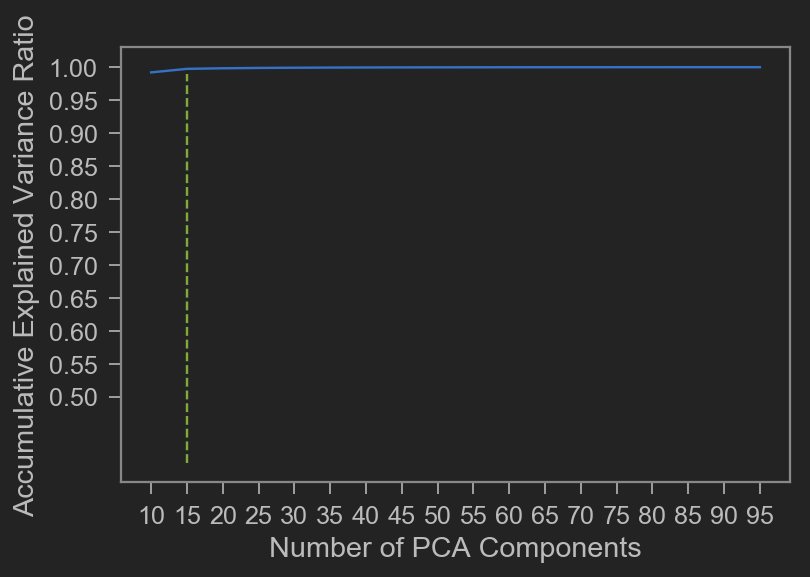

In [36]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
n_components = range(10,100,5)
acc_explained_ratio = []

for n in n_components:
    pca = PCA(n_components=n)
    pca.fit_transform(X)
    acc_explained_ratio.append(np.sum(pca.explained_variance_ratio_))
plt.figure(figsize=(6,4),dpi=144)
plt.plot(n_components,acc_explained_ratio)
plt.xlabel("Number of PCA Components")
plt.ylabel("Accumulative Explained Variance Ratio")
plt.yticks(np.arange(0.5,1.05,0.05))
plt.xticks(np.arange(0,100,5))
plt.plot((15,15),(0.4,0.99),"g--")
plt.show()

In [39]:
n_components = 15
pca_model = PCA(n_components=n_components).fit(train_x)
pca_train_x = pca_model.transform(train_x)
pca_test_x = pca_model.transform(test_x)
param_grid = {"C":[1,5,10,50],"gamma":[0.0001,0.0005,0.001,0.005,0.01],
              "kernel":["rbf"],"class_weight":["balanced"]}
SVC_PCA_model = GridSearchCV(SVC(),param_grid,verbose=2,n_jobs=4)
SVC_PCA_model.fit(pca_train_x,train_y)
print("-----SVM Classifier(PCA)------\n",
      "best param:{0}\nbest score:{1}".format(SVC_PCA_model.best_params_,SVC_PCA_model.best_score_))

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   54.7s
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  1.5min finished


-----SVM Classifier(PCA)------
 best param:{'C': 50, 'class_weight': 'balanced', 'gamma': 0.01, 'kernel': 'rbf'}
best score:0.79575


In [41]:
y_pred = SVC_PCA_model.best_estimator_.predict(pca_test_x)
print("------Confusion Matrix------\n",confusion_matrix(test_y,y_pred))
print("-----Classification_report-----\n",classification_report(test_y,y_pred))

------Confusion Matrix------
 [[2281  585]
 [  78   56]]
-----Classification_report-----
              precision    recall  f1-score   support

          0       0.97      0.80      0.87      2866
          1       0.09      0.42      0.14       134

avg / total       0.93      0.78      0.84      3000



# K-Means

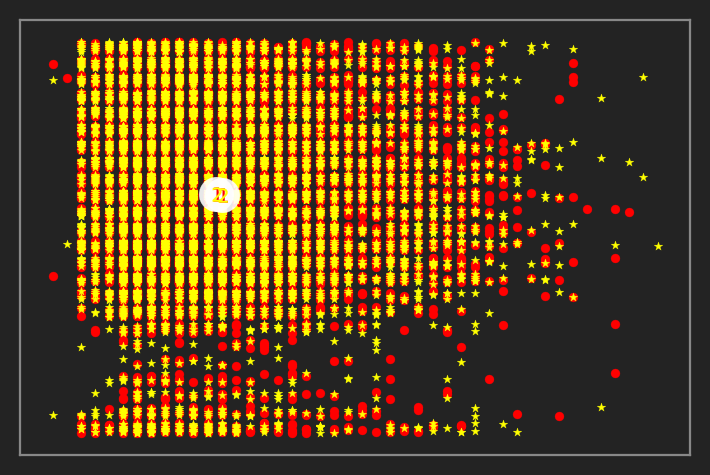

In [39]:
from sklearn.cluster import KMeans
kmean = KMeans(n_clusters=2)
kmean.fit(X)
kmean_score = kmean.score(X)

labels = kmean.labels_
centers = kmean.cluster_centers_
plt.figure(figsize=(6,4),dpi=144)
plt.xticks(())
plt.yticks(())
plt.scatter(X[labels==0].iloc[:,0],X[labels==0].iloc[:,1],marker="o",s=20,c="red")
plt.scatter(X[labels==1].iloc[:,0],X[labels==1].iloc[:,1],marker="*",s=20,c="yellow")
plt.scatter(centers[:,0],centers[:,1],marker="o",c="white",alpha=0.9,s=300)
plt.scatter(centers[:,0],centers[:,1],marker="$1$",c="red",s=50)
plt.scatter(centers[:,0],centers[:,1],marker="$2$",c="yellow",s=50)

In [40]:
from sklearn.metrics import adjusted_rand_score,homogeneity_score,completeness_score,v_measure_score
AR_score = adjusted_rand_score(y,labels)
H_score = homogeneity_score(y,labels)
C_score = completeness_score(y,labels)
V_score = v_measure_score(y,labels)
print("Adjusted Rand-Index:",AR_score,"\n",
     "Homogeneity Score:",H_score,"\n",
     "Completeness Score:",C_score,"\n",
     "V-measure Score:",V_score)

Adjusted Rand-Index: 0.0027599712496652125 
 Homogeneity Score: 0.01662842545061333 
 Completeness Score: 0.004487396252852615 
 V-measure Score: 0.0070675283307278045


# KNN

------KNeighborsClassifier------
elaspe: 305.2950389313734 
 train_score: 0.9540508947037137 
 test_score: 0.9538834951456311
------classification_report------
              precision    recall  f1-score   support

          0       0.95      1.00      0.98      3537
          1       0.00      0.00      0.00       171

avg / total       0.91      0.95      0.93      3708

auc: 0.5
auc: 0.7692927068401377
Confusion matrix, without normalization
[[3537    0]
 [ 171    0]]


F:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


------KNeighborsClassifier------
elaspe: 305.5213248479308 
 train_score: 1.0 
 test_score: 0.953344120819849
------classification_report------
              precision    recall  f1-score   support

          0       0.95      1.00      0.98      3537
          1       0.25      0.01      0.01       171

avg / total       0.92      0.95      0.93      3708

auc: 0.5024998883978394
auc: 0.7692927068401377
Confusion matrix, without normalization
[[3534    3]
 [ 170    1]]
------RadiusNeighborsClassifier------
elaspe: 436.63880084495827 
 train_score: 0.9538710547612624 
 test_score: 0.9538834951456311
------classification_report------
              precision    recall  f1-score   support

          0       0.95      1.00      0.98      3537
          1       0.00      0.00      0.00       171

avg / total       0.91      0.95      0.93      3708

auc: 0.5
auc: 0.7692927068401377
Confusion matrix, without normalization
[[3537    0]
 [ 171    0]]


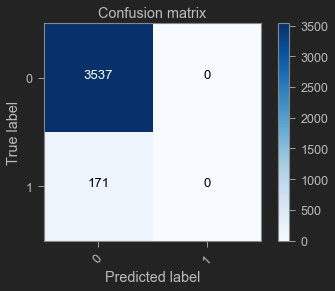

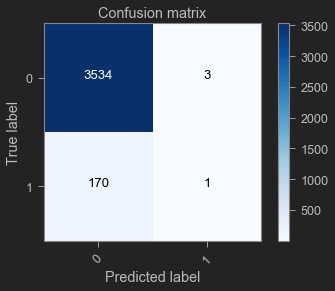

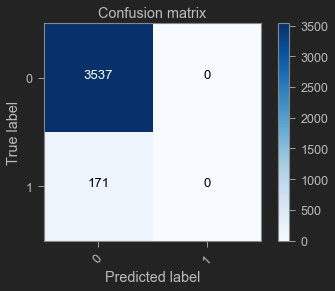

In [29]:
from sklearn.neighbors import KNeighborsClassifier,RadiusNeighborsClassifier
knn_model1 = KNeighborsClassifier(n_neighbors=10)
knn_model2 = KNeighborsClassifier(n_neighbors=10,weights="distance")
knn_model3 = RadiusNeighborsClassifier(n_neighbors=10,radius=1000.0)

models = [knn_model1,knn_model2,knn_model3]
for knn in models:
    start = time.clock()
    knn.fit(train_x,train_y)
    train_score = knn.score(train_x,train_y)
    test_score = knn.score(test_x,test_y)
    y_pred = knn.predict(test_x)
    print("------"+knn.__class__.__name__+"------\n"
          "elaspe:",time.clock()-start,"\n",
          "train_score:",train_score,"\n",
          "test_score:",test_score)
    cm = confusion_matrix(test_y,y_pred)
    eval_info(test_y,y_pred,y_score,cm)

# naive bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB,BernoulliNB
import time

GNB = GaussianNB()
BNB = BernoulliNB()
# models = [GNB,BNB]
# for NB in models:
start = time.clock()
GNB.fit(train_x,train_y)
train_score = GNB.score(train_x,train_y)
test_score = GNB.score(test_x,test_y)
print("elaspe:",time.clock()-start,"\n",
          "train_score:",train_score,"\n",
          "test_score:",test_score)
# y_pred = GNB.predict(test_x)
y_pred_prob1 = GNB.predict_proba(test_x)[:,1]

start = time.clock()
BNB.fit(train_x,train_y)
train_score = BNB.score(train_x,train_y)
test_score = BNB.score(test_x,test_y)
print("elaspe:",time.clock()-start,"\n",
          "train_score:",train_score,"\n",
          "test_score:",test_score)
# y_pred = GNB.predict(test_x)
y_pred_prob2 = BNB.predict_proba(test_x)[:,1]

y_pred_prob = y_pred_prob1 + y_pred_prob2
y_pred = np.where(y_pred_prob>0.5,1,0)

cm = confusion_matrix(test_y,y_pred)
eval_info(NB,test_y,y_pred_prob,cm)